# 😕 **전체 흐름**
```
현재 위치: Step 1 (RFM) ✅ 완료

↓

Step 2: Monetary 특성 추가 ✅ 완료

↓

Step 3: Product/Category 특성 추가 ✅ 완료

↓

Step 4: Review 특성 추가 ✅ 완료

↓

Step 5: Payment 특성 추가 ✅ 완료

↓

Step 6: 모든 특성 병합 및 전처리 ✅ 완료
  - 결측치 처리
  - 이상치 처리
  - 범주형 변수 인코딩
  - **스케일링 (StandardScaler)** ⭐ 매우 중요!

↓

Step 7: Hierarchical Clustering 적용 ⭐ ✅ 완료
  - Linkage 방법 비교 (ward, average, complete)
  - 덴드로그램 그리기
  - 최적 클러스터 개수 결정
  - 클러스터 할당

↓

Step 8: 결과 해석 및 시각화 ✅ 완료
  - 클러스터별 프로파일링
  - 비즈니스 인사이트 도출
```

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"heewonlee2","key":"f2c15a4ce035a2f9c9b147d2a3c5f660"}'}

In [ ]:
import os

# Create a .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle
# Move the uploaded kaggle.json to the .kaggle directory
!mv kaggle.json ~/.kaggle/
# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

Now that the `kaggle.json` file is in the correct location with the right permissions, you can try downloading the dataset again.

In [ ]:
#!/bin/bash
!kaggle datasets download olistbr/brazilian-ecommerce

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
 96% 41.0M/42.6M [00:00<00:00, 429MB/s]
100% 42.6M/42.6M [00:00<00:00, 421MB/s]


In [ ]:
!unzip brazilian-ecommerce.zip

Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [ ]:
# ============================================
# Olist E-commerce 고객 세분화 분석
# Step 1: 데이터 조인 및 RFM 계산 (정확한 버전)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 60)
print("Step 1: Data Loading & Joining")
print("=" * 60)

Step 1: Data Loading & Joining


In [ ]:
# --------------------------------------------
# 1.1 데이터 로드
# --------------------------------------------

# 필요한 테이블들 로드
orders = pd.read_csv('olist_orders_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

print("\n✅ Data loaded successfully!")
print(f"Orders: {len(orders):,} rows")
print(f"Customers: {len(customers):,} rows")
print(f"Payments: {len(payments):,} rows")
print(f"Order Items: {len(order_items):,} rows")
print(f"Products: {len(products):,} rows")
print(f"Reviews: {len(reviews):,} rows")


✅ Data loaded successfully!
Orders: 99,441 rows
Customers: 99,441 rows
Payments: 103,886 rows
Order Items: 112,650 rows
Products: 32,951 rows
Reviews: 99,224 rows


In [ ]:
# --------------------------------------------
# 1.2 Orders + Customers 조인 (핵심!)
# --------------------------------------------

# Orders와 Customers를 조인하여 실제 고객 ID 매핑
# 왜? customer_id는 주문마다 생성, customer_unique_id가 실제 고객 구분자
orders_customers = orders.merge(
    customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']],
    on='customer_id',
    how='left'
)

print("\n" + "=" * 60)
print("Step 2: Data Preprocessing")
print("=" * 60)

# 날짜 컬럼을 datetime으로 변환
orders_customers['order_purchase_timestamp'] = pd.to_datetime(orders_customers['order_purchase_timestamp'])
# 주문 상태 확인
print("\n📋 Order Status Distribution:")
print(orders_customers['order_status'].value_counts())


Step 2: Data Preprocessing

📋 Order Status Distribution:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


In [ ]:
# Delivered 주문만 필터링
# 왜? 실제 완료된 거래만 분석해야 정확한 고객 행동 파악
orders_delivered = orders_customers[orders_customers['order_status'] == 'delivered'].copy()

print(f"\n✅ Filtered to 'delivered' orders only:")
print(f"   Before: {len(orders_customers):,} → After: {len(orders_delivered):,}")


✅ Filtered to 'delivered' orders only:
   Before: 99,441 → After: 96,478


In [ ]:
# 분석 기준일 설정
reference_date = orders_delivered['order_purchase_timestamp'].max()
print(f"\n📅 Analysis Reference Date: {reference_date}")
print(f"   Data Period: {orders_delivered['order_purchase_timestamp'].min()} ~ {reference_date}")


📅 Analysis Reference Date: 2018-08-29 15:00:37
   Data Period: 2016-09-15 12:16:38 ~ 2018-08-29 15:00:37


In [ ]:
# --------------------------------------------
# 1.3 RFM 계산 (customer_unique_id 기준)
# --------------------------------------------

print("\n" + "=" * 60)
print("Step 3: RFM Calculation")
print("=" * 60)

# customer_unique_id로 그룹화 (실제 고객 기준)
rfm = orders_delivered.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': [
        ('last_purchase_date', 'max'),      # 마지막 구매일
        ('first_purchase_date', 'min')       # 첫 구매일
    ],
    'order_id': [
        ('frequency', 'count')               # 총 주문 횟수
    ]
}).reset_index()

# 컬럼명 정리
rfm.columns = ['customer_unique_id', 'last_purchase_date', 'first_purchase_date', 'frequency']

# Recency 계산: 기준일 - 마지막 구매일
rfm['recency'] = (reference_date - rfm['last_purchase_date']).dt.days

# 고객 생애 기간 계산
rfm['customer_lifetime_days'] = (rfm['last_purchase_date'] - rfm['first_purchase_date']).dt.days

print(f"\n✅ RFM Calculated!")
print(f"   Total Unique Customers: {len(rfm):,}")


Step 3: RFM Calculation

✅ RFM Calculated!
   Total Unique Customers: 93,358


In [ ]:
# --------------------------------------------
# 1.4 RFM 기본 통계
# --------------------------------------------

print("\n📊 RFM Basic Statistics:")
print(rfm[['recency', 'frequency', 'customer_lifetime_days']].describe())

# Frequency 상세 분포
print("\n📊 Frequency Detailed Distribution:")
freq_dist = rfm['frequency'].value_counts().sort_index()
print(freq_dist.head(10))


📊 RFM Basic Statistics:
            recency     frequency  customer_lifetime_days
count  93358.000000  93358.000000            93358.000000
mean     236.941773      1.033420                2.634032
std      152.591453      0.209097               24.955822
min        0.000000      1.000000                0.000000
25%      113.000000      1.000000                0.000000
50%      218.000000      1.000000                0.000000
75%      345.000000      1.000000                0.000000
max      713.000000     15.000000              633.000000

📊 Frequency Detailed Distribution:
frequency
1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64


In [ ]:
# Frequency 비율
print("\n📊 Frequency Ratio:")
total_customers = len(rfm)
print(f"1-time customers:    {(rfm['frequency'] == 1).sum():,} ({(rfm['frequency'] == 1).sum() / total_customers * 100:.1f}%)")
print(f"2-3 times:           {((rfm['frequency'] >= 2) & (rfm['frequency'] <= 3)).sum():,} ({((rfm['frequency'] >= 2) & (rfm['frequency'] <= 3)).sum() / total_customers * 100:.1f}%)")
print(f"4-5 times:           {((rfm['frequency'] >= 4) & (rfm['frequency'] <= 5)).sum():,} ({((rfm['frequency'] >= 4) & (rfm['frequency'] <= 5)).sum() / total_customers * 100:.1f}%)")
print(f"6+ times:            {(rfm['frequency'] >= 6).sum():,} ({(rfm['frequency'] >= 6).sum() / total_customers * 100:.1f}%)")


📊 Frequency Ratio:
1-time customers:    90,557 (97.0%)
2-3 times:           2,754 (2.9%)
4-5 times:           37 (0.0%)
6+ times:            10 (0.0%)


In [ ]:
# 충성 고객 (5회 이상 구매)
loyal_customers = rfm[rfm['frequency'] >= 5]
print(f"\n🏆 Loyal Customers (5+ purchases): {len(loyal_customers):,}")
if len(loyal_customers) > 0:
    print("\nTop 10 Most Loyal Customers:")
    print(loyal_customers.nlargest(10, 'frequency')[['customer_unique_id', 'frequency', 'recency', 'customer_lifetime_days']])


🏆 Loyal Customers (5+ purchases): 19

Top 10 Most Loyal Customers:
                     customer_unique_id  frequency  recency  \
51431  8d50f5eadf50201ccdcedfb9e2ac8455         15        8   
22779  3e43e6105506432c953e165fb2acf44c          9      182   
10060  1b6c7548a2a1f9037c1fd3ddfed95f33          7      196   
36706  6469f99c1f9dfae7733b25662e7f1782          7       62   
73921  ca77025e7201e3b30c44b472ff346268          7       89   
6964   12f5d6e1cbf93dafd9dcc19095df0b3d          6      600   
26257  47c1a3033b8b77b3ab6e109eb4d5fdf3          6      216   
36500  63cfc61cee11cbe306bff5857d00bfe4          6       92   
80538  dc813062e0fc23409cd255f7f53c7074          6        6   
87885  f0e310a6839dce9de1638e0fe5ab282a          6      146   

       customer_lifetime_days  
51431                     427  
22779                     161  
10060                      92  
36706                     281  
73921                     234  
6964                        0  
26257         


Step 4: Visualization


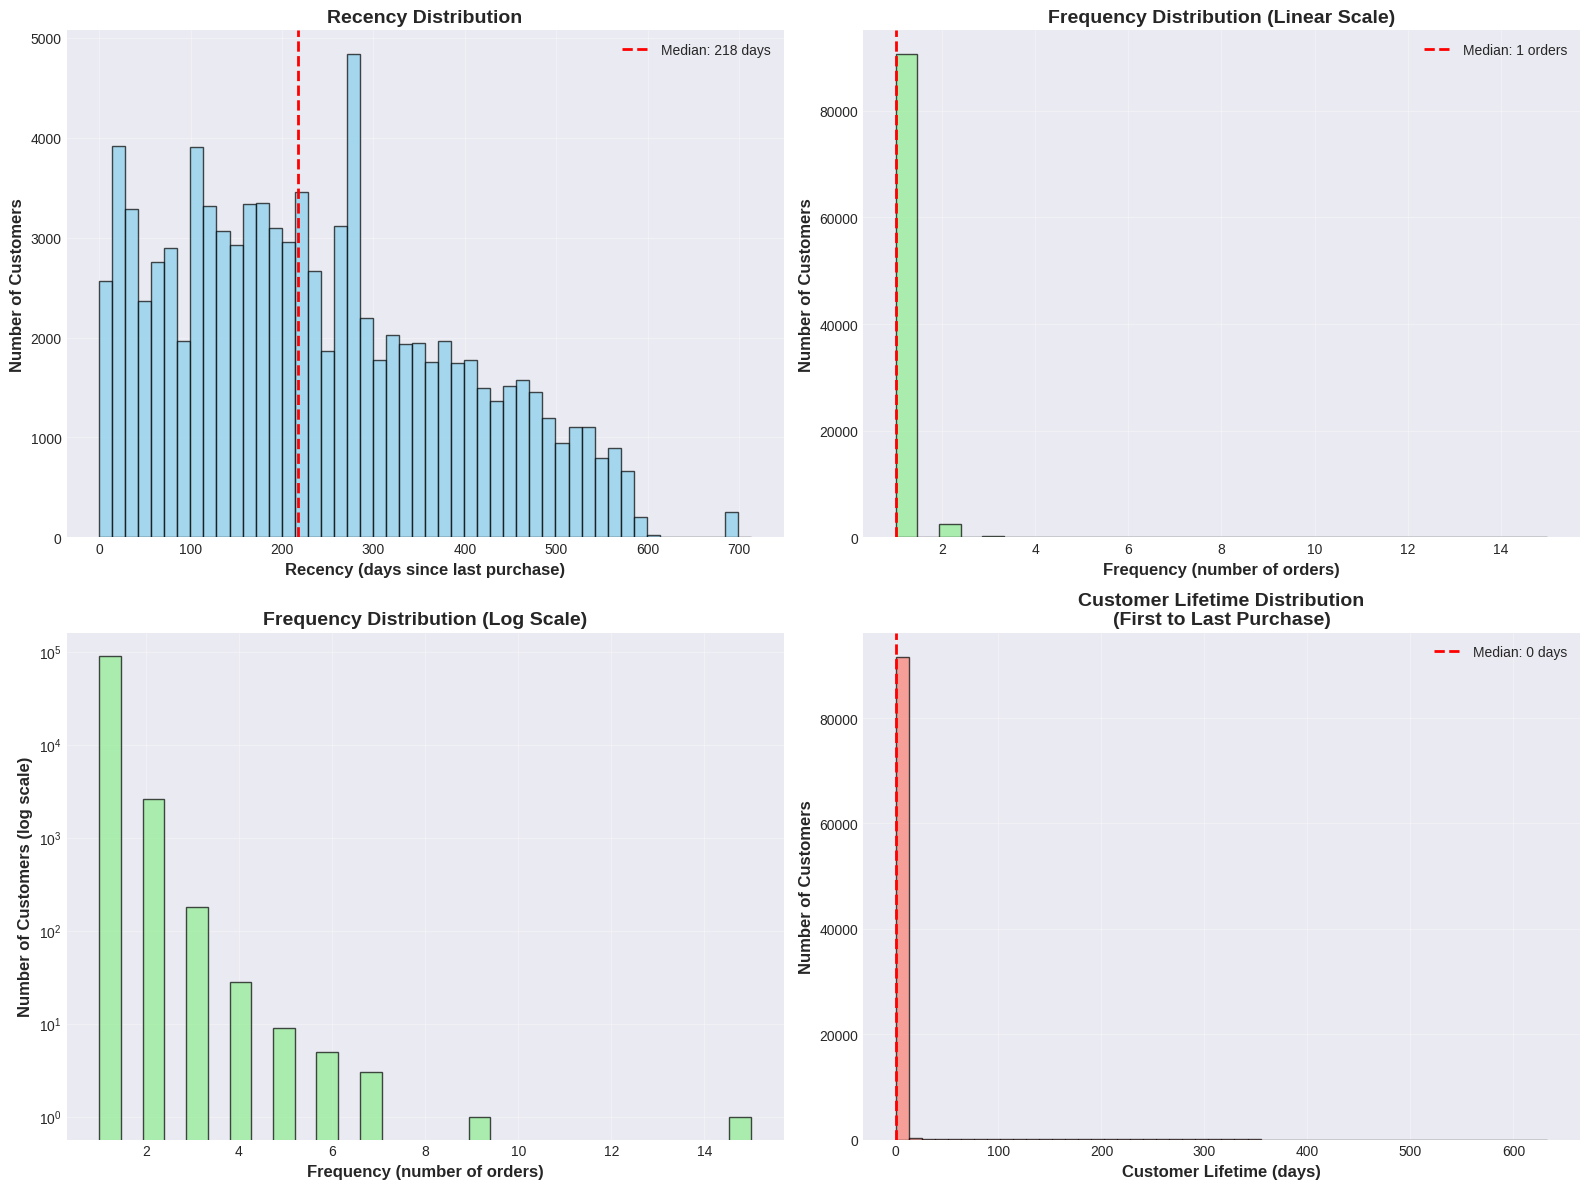

In [ ]:
# --------------------------------------------
# 1.5 시각화
# --------------------------------------------

print("\n" + "=" * 60)
print("Step 4: Visualization")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recency Distribution : 최근성 분포 (마지막 구매 후 경과일)
# (의미: 그래프가 왼쪽(0일)에 쏠려 있을수록 최근에 구매한 활성 고객이 많다는 뜻이며,
#        오른쪽으로 길게 꼬리가 있다면 이탈한 지 오래된 '휴면 고객'이 많다는 의미입니다.)
axes[0, 0].hist(rfm['recency'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(rfm['recency'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {rfm["recency"].median():.0f} days')
axes[0, 0].set_xlabel('Recency (days since last purchase)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Frequency Distribution (Linear Scale) : 구매 빈도 분포 (일반 척도)
# (의미: 보통 이커머스는 '1회 구매자'가 압도적으로 많습니다.
#        이 그래프를 통해 단발성 구매자와 재구매자의 비율 차이를 직관적으로 확인합니다.)
axes[0, 1].hist(rfm['frequency'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(rfm['frequency'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {rfm["frequency"].median():.0f} orders')
axes[0, 1].set_xlabel('Frequency (number of orders)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Frequency Distribution (Linear Scale)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Frequency Distribution (Log Scale) - 극단적 분포 확인 : 구매 빈도 분포 (로그 척도)
# (의미: 위 2번 그래프에서 1회 구매자가 너무 많아 '다빈도 구매자(VVIP)'가 보이지 않을 때 사용합니다.
#        Y축을 로그로 변환하여, 숨어있는 소수의 '충성 고객' 분포를 확대해서 보는 효과가 있습니다.)
axes[1, 0].hist(rfm['frequency'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Frequency (number of orders)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers (log scale)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Frequency Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# 4. Customer Lifetime Distribution : 고객 수명 분포 (첫 구매 ~ 마지막 구매 간격)
# (의미: 0에 몰려 있다면 한 번 사고 다시 안 온 고객(이탈)이 많다는 뜻이고,
#        수치가 높고 넓게 퍼져 있다면 오랫동안 우리와 관계를 맺은 충성 고객층이 두텁다는 뜻입니다.)
axes[1, 1].hist(rfm['customer_lifetime_days'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(rfm['customer_lifetime_days'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {rfm["customer_lifetime_days"].median():.0f} days')
axes[1, 1].set_xlabel('Customer Lifetime (days)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Customer Lifetime Distribution\n(First to Last Purchase)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# Step 2: Monetary Features (금액 관련 특성)
# ============================================

print("\n" + "=" * 60)
print("Step 2: Monetary Features Calculation")
print("=" * 60)

# Step 1에서 만든 rfm DataFrame에서 필요한 컬럼만 추출
rfm_features = rfm[['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days']].copy()


Step 2: Monetary Features Calculation


In [ ]:
# --------------------------------------------
# 2.1 Payments 데이터 준비
# --------------------------------------------

# Payments 테이블 확인
print("\n📋 Payments Table Info:")
print(f"Total payment records: {len(payments):,}")
print(f"Columns: {payments.columns.tolist()}")
print("\nSample:")
print(payments.head())


📋 Payments Table Info:
Total payment records: 103,886
Columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Sample:
                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45  


In [ ]:
# 결제 타입 분포 확인
print("\n📊 Payment Type Distribution:")
print(payments['payment_type'].value_counts())


📊 Payment Type Distribution:
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64


In [ ]:
# payment_installments (할부 개월 수) 확인
print("\n📊 Payment Installments Distribution:")
print(payments['payment_installments'].value_counts().head(10))


📊 Payment Installments Distribution:
payment_installments
1     52546
2     12413
3     10461
4      7098
10     5328
5      5239
8      4268
6      3920
7      1626
9       644
Name: count, dtype: int64


In [ ]:
# --------------------------------------------
# 2.2 Orders + Payments 조인
# --------------------------------------------

# Orders (delivered)와 Payments 조인
# 왜? 각 주문의 결제 정보를 가져오기 위해
# 참고: 한 주문에 여러 결제 방식 사용 가능 (예: 신용카드 + 쿠폰)
orders_payments = orders_delivered.merge(
    payments[['order_id', 'payment_type', 'payment_installments', 'payment_value']],
    on='order_id',
    how='left'
)

print(f"\n✅ Orders + Payments joined:")
print(f"   Rows: {len(orders_payments):,}")


✅ Orders + Payments joined:
   Rows: 100,757


In [ ]:
# --------------------------------------------
# 2.3 고객별 Monetary 특성 계산
# --------------------------------------------

# customer_unique_id별로 집계
monetary_features = orders_payments.groupby('customer_unique_id').agg({
    'payment_value': [
        ('monetary', 'sum'),              # 총 구매 금액 (M in RFM)
        ('avg_order_value', 'mean'),      # 평균 주문 금액
        ('min_order_value', 'min'),       # 최소 주문 금액
        ('max_order_value', 'max')        # 최대 주문 금액
    ],
    'payment_installments': [
        ('avg_installments', 'mean'),     # 평균 할부 개월 수
        ('max_installments', 'max')       # 최대 할부 개월 수
    ]
}).reset_index()

# 컬럼명 정리
monetary_features.columns = [
    'customer_unique_id',
    'monetary',
    'avg_order_value',
    'min_order_value',
    'max_order_value',
    'avg_installments',
    'max_installments'
]

In [ ]:
monetary_features.head()

,customer_unique_id,monetary,avg_order_value,min_order_value,max_order_value,avg_installments,max_installments
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,141.90,141.90,141.90,8.0,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,27.19,27.19,27.19,1.0,1.0
2,0000f46a3911fa3c0805444483337064,86.22,86.22,86.22,86.22,8.0,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,43.62,43.62,43.62,4.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,196.89,196.89,196.89,196.89,6.0,6.0


In [ ]:
# 주문 금액 표준편차 계산 (구매 금액 일관성)
# 표준편차 높음 = 때로는 비싸게, 때로는 싸게 구매
# 표준편차 낮음 = 비슷한 금액대 구매
order_value_std = orders_payments.groupby('customer_unique_id')['payment_value'].std().reset_index()
order_value_std.columns = ['customer_unique_id', 'order_value_std']
order_value_std['order_value_std'] = order_value_std['order_value_std'].fillna(0)  # 1회 구매는 std=NaN → 0

monetary_features = monetary_features.merge(order_value_std, on='customer_unique_id', how='left')

print(f"\n✅ Monetary features calculated!")
print(f"   Total customers: {len(monetary_features):,}")


✅ Monetary features calculated!
   Total customers: 93,358


In [ ]:
# --------------------------------------------
# 2.4 결제 타입 선호도 계산
# --------------------------------------------

# 각 고객이 가장 많이 사용한 결제 방식
# 왜? 결제 습관은 경제력, 신용도와 연관
payment_type_mode = orders_payments.groupby('customer_unique_id')['payment_type'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown'
).reset_index()
payment_type_mode.columns = ['customer_unique_id', 'payment_type_most_common']

monetary_features = monetary_features.merge(payment_type_mode, on='customer_unique_id', how='left')

# 신용카드 사용 비율 계산
# 왜? 신용카드 사용 = 신용도, 디지털 친화도
credit_card_ratio = orders_payments.groupby('customer_unique_id').apply(
    lambda x: (x['payment_type'] == 'credit_card').sum() / len(x)
).reset_index()
credit_card_ratio.columns = ['customer_unique_id', 'credit_card_usage_ratio']

monetary_features = monetary_features.merge(credit_card_ratio, on='customer_unique_id', how='left')

print(f"\n✅ Payment preference features added!")


✅ Payment preference features added!


In [ ]:
# --------------------------------------------
# 2.5 Monetary 기본 통계
# --------------------------------------------

print("\n📊 Monetary Features Statistics:")
print(monetary_features[['monetary', 'avg_order_value', 'avg_installments', 'credit_card_usage_ratio']].describe())


📊 Monetary Features Statistics:
           monetary  avg_order_value  avg_installments  \
count  93358.000000     93357.000000       93357.00000   
mean     165.197003       157.653522           2.89933   
std      226.314012       216.870922           2.67563   
min        0.000000         1.856818           0.00000   
25%       63.052500        60.700000           1.00000   
50%      107.780000       103.550000           2.00000   
75%      182.557500       174.520000           4.00000   
max    13664.080000     13664.080000          24.00000   

       credit_card_usage_ratio  
count             93358.000000  
mean                  0.757970  
std                   0.421079  
min                   0.000000  
25%                   0.500000  
50%                   1.000000  
75%                   1.000000  
max                   1.000000  


In [ ]:
# 고액 구매 고객 TOP 10
print("\n🏆 Top 10 Highest Spending Customers:")
print(monetary_features.nlargest(10, 'monetary')[
    ['customer_unique_id', 'monetary', 'avg_order_value', 'avg_installments', 'payment_type_most_common']
])


🏆 Top 10 Highest Spending Customers:
                     customer_unique_id  monetary  avg_order_value  \
3724   0a0a92112bd4c708ca5fde585afaa872  13664.08       13664.0800   
79636  da122df9eeddfedc1dc1f5349a1a690c   7571.63        3785.8150   
43168  763c8b1c9c68a0229c42c9fc6f662b93   7274.88        7274.8800   
80463  dc4802a71eae9be1dd28f5d788ceb526   6929.31        6929.3100   
25436  459bef486812aa25204be022145caa62   6922.21        6922.2100   
93081  ff4159b92c40ebe40454e3e6a7c35ed6   6726.66        6726.6600   
23411  4007669dec559734d6f53e029e360987   6081.54        6081.5400   
87148  eebb5dda148d3893cdaf5b5ca3040ccb   4764.34        4764.3400   
26640  48e1ac109decbb87765a3eade6854098   4681.78        4681.7800   
73127  c8460e4251689ba205045f3ea17884a1   4655.91        1163.9775   

       avg_installments payment_type_most_common  
3724                1.0              credit_card  
79636              10.0              credit_card  
43168               1.0               

In [ ]:
# 결제 타입 분포
print("\n📊 Most Common Payment Type Distribution:")
print(monetary_features['payment_type_most_common'].value_counts())


📊 Most Common Payment Type Distribution:
payment_type_most_common
credit_card    71491
boleto         18698
voucher         1745
debit_card      1423
unknown            1
Name: count, dtype: int64



Step 2: Visualization


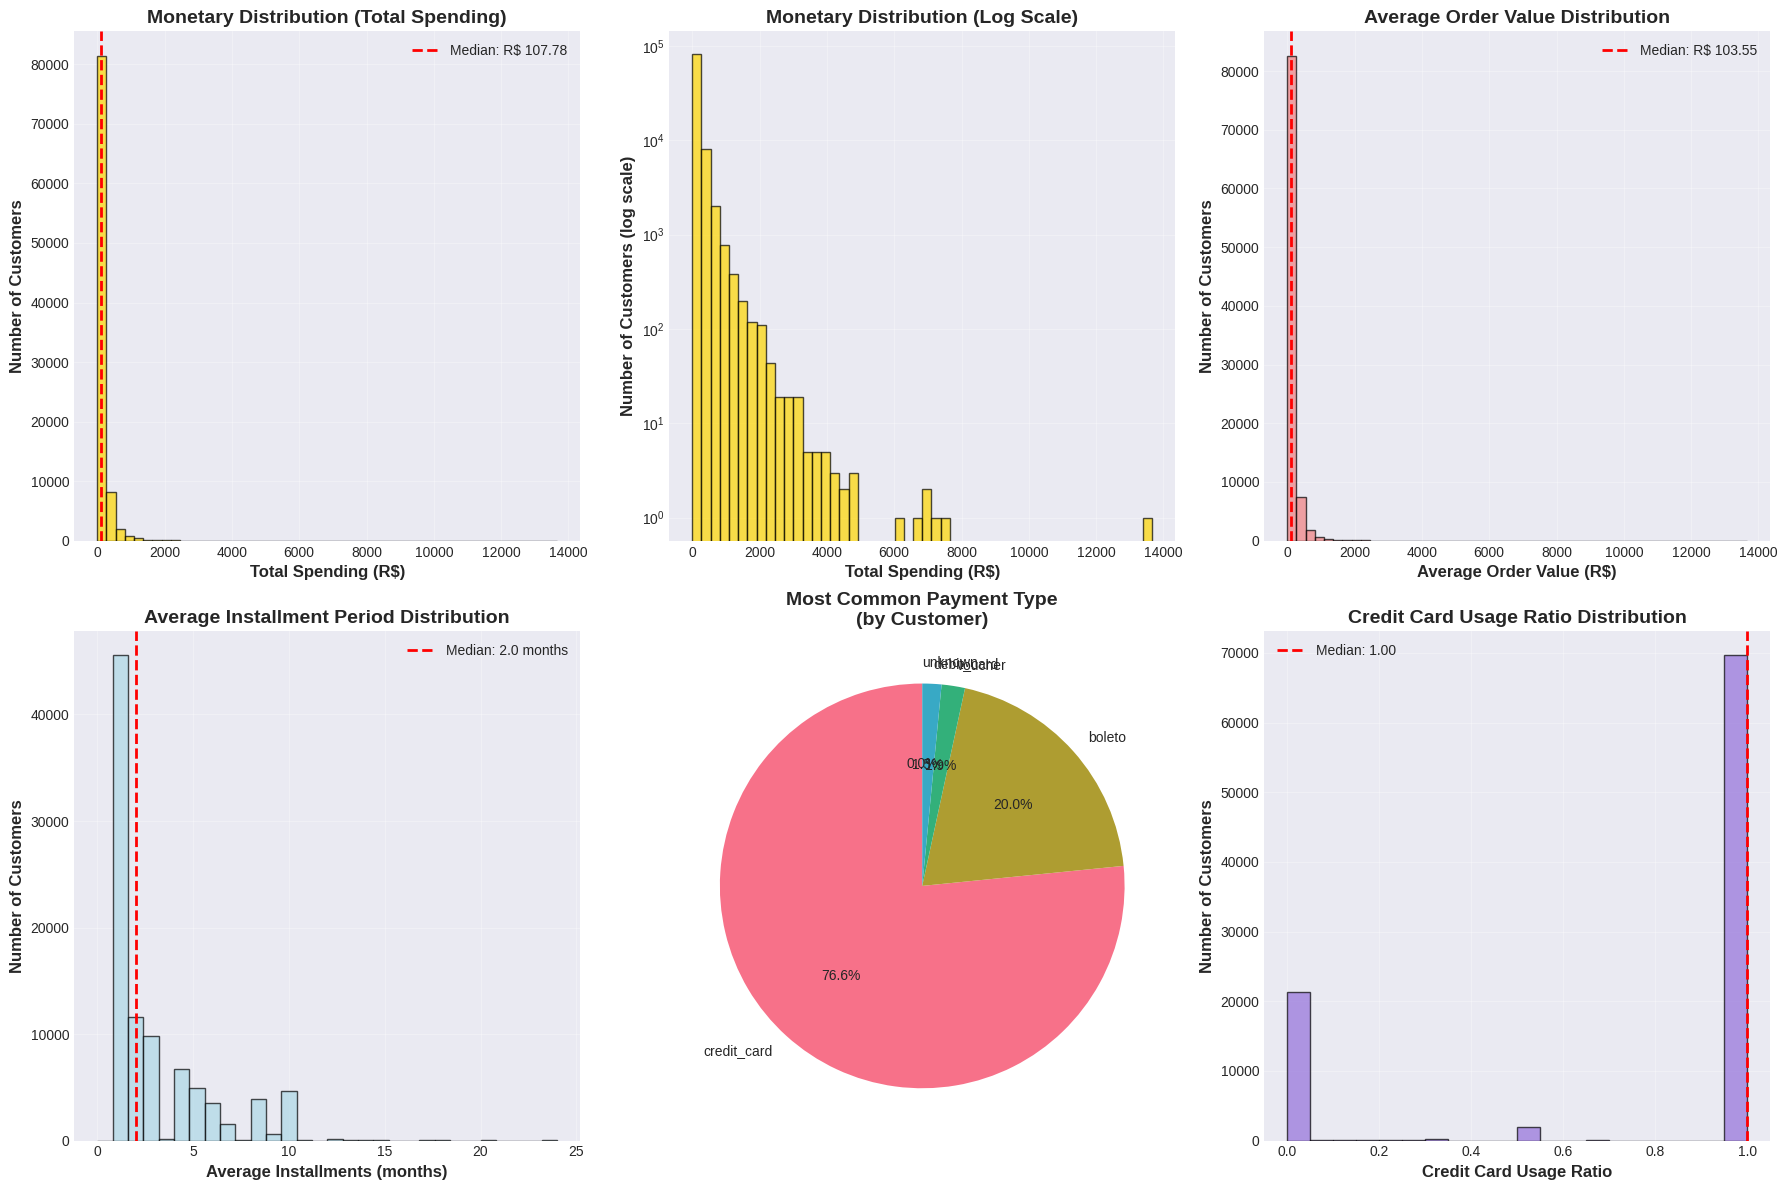

In [ ]:
# --------------------------------------------
# 2.6 시각화
# --------------------------------------------

print("\n" + "=" * 60)
print("Step 2: Visualization")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Monetary Distribution : 총 지출액 분포
# (의미: 고객별 생애 총 결제 금액(LTV의 기초)을 봅니다.
#        그래프가 왼쪽에 쏠려 있다면 소액 구매자가 대다수라는 뜻입니다.)
axes[0, 0].hist(monetary_features['monetary'], bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(monetary_features['monetary'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: R$ {monetary_features["monetary"].median():.2f}')
axes[0, 0].set_xlabel('Total Spending (R$)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Monetary Distribution (Total Spending)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Monetary Distribution (Log Scale) - 극단값 확인 : 총 지출액 분포 (로그 스케일)
# (의미: 매출 데이터는 빈부격차가 심해 1번 그래프로는 고액 구매자(VIP)가 잘 안 보입니다.
#        로그 변환을 통해 숨어있는 고액 결제 패턴의 전체적인 형태를 확인합니다.)
axes[0, 1].hist(monetary_features['monetary'], bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Total Spending (R$)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers (log scale)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Monetary Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# 3. Average Order Value Distribution : 평균 주문 금액(객단가) 분포
# (의미: '한 번 지갑을 열 때 얼마를 쓰는가?'를 나타냅니다.
#        이 수치가 높다면 '프리미엄 제품' 위주의 마케팅이 효과적일 수 있습니다.)
axes[0, 2].hist(monetary_features['avg_order_value'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(monetary_features['avg_order_value'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: R$ {monetary_features["avg_order_value"].median():.2f}')
axes[0, 2].set_xlabel('Average Order Value (R$)', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Average Order Value Distribution', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(alpha=0.3)

# 4. Average Installments Distribution : 평균 할부 개월 수 분포
# (의미: 브라질(Olist 데이터)이나 고가 시장에서 중요한 지표입니다.
#        할부 개월 수가 높다면 '고가 상품 구매자'이거나 '현금 유동성이 낮은 고객'일 수 있습니다.)
axes[1, 0].hist(monetary_features['avg_installments'], bins=30, color='lightblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(monetary_features['avg_installments'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {monetary_features["avg_installments"].median():.1f} months')
axes[1, 0].set_xlabel('Average Installments (months)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Average Installment Period Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# 5. Payment Type Distribution (Pie Chart) : 주 이용 결제 수단 비율
# (의미: 고객들이 신용카드, 계좌이체, 바우처 중 무엇을 선호하는지 파악하여
#        결제 편의성 개선이나 특정 결제 수단 프로모션 전략을 짤 때 사용합니다.)
payment_counts = monetary_features['payment_type_most_common'].value_counts()
axes[1, 1].pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("husl", len(payment_counts)))
axes[1, 1].set_title('Most Common Payment Type\n(by Customer)', fontsize=14, fontweight='bold')

# 6. Credit Card Usage Ratio Distribution : 신용카드 이용 비중 분포
# (의미: 0과 1 양쪽 끝에 데이터가 몰려있을 가능성이 큽니다.
#        1.0(100%)인 고객은 충동구매 가능성이 상대적으로 높거나, 할부 프로모션에 민감할 수 있습니다.)
axes[1, 2].hist(monetary_features['credit_card_usage_ratio'], bins=20, color='mediumpurple',
                edgecolor='black', alpha=0.7)
axes[1, 2].axvline(monetary_features['credit_card_usage_ratio'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {monetary_features["credit_card_usage_ratio"].median():.2f}')
axes[1, 2].set_xlabel('Credit Card Usage Ratio', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Credit Card Usage Ratio Distribution', fontsize=14, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------
# 2.7 RFM + Monetary 병합
# --------------------------------------------

# RFM과 Monetary 특성 병합
rfm_monetary = rfm_features.merge(monetary_features, on='customer_unique_id', how='left')

print(f"\n✅ RFM + Monetary merged!")
print(f"   Total features: {len(rfm_monetary.columns) - 1}")  # -1 for customer_id
print(f"   Feature list: {rfm_monetary.columns.tolist()}")


✅ RFM + Monetary merged!
   Total features: 12
   Feature list: ['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days', 'monetary', 'avg_order_value', 'min_order_value', 'max_order_value', 'avg_installments', 'max_installments', 'order_value_std', 'payment_type_most_common', 'credit_card_usage_ratio']


In [ ]:
# --------------------------------------------
# 2.8 초기 인사이트
# --------------------------------------------

print("\n" + "=" * 60)
print("구매 금액(Monetary) 특성 분석 결과")
print("=" * 60)

high_value = monetary_features['monetary'].quantile(0.8)
low_value = monetary_features['monetary'].quantile(0.2)

print(f"""
💰 지출 패턴 분석:

1. 총 지출액 (Monetary):
   - 중앙값 (Median): R$ {monetary_features['monetary'].median():.2f}
   - 평균 (Mean): R$ {monetary_features['monetary'].mean():.2f}
   - 상위 20% 기준값: R$ {high_value:.2f}
   - 하위 20% 기준값: R$ {low_value:.2f}

2. 평균 주문 금액 (객단가, AOV):
   - 중앙값: R$ {monetary_features['avg_order_value'].median():.2f}
   - 평균: R$ {monetary_features['avg_order_value'].mean():.2f}

3. 결제 선호도:
   - 최빈 결제 수단: {monetary_features['payment_type_most_common'].mode()[0]}
   - 신용카드 사용 비율: {monetary_features['credit_card_usage_ratio'].mean() * 100:.1f}% (평균)

4. 할부 이용 현황:
   - 평균 할부 개월 수: {monetary_features['avg_installments'].mean():.1f}개월
   - 할부 이용 고객 비율 (>1개월): {(monetary_features['avg_installments'] > 1).sum() / len(monetary_features) * 100:.1f}%
""")

print("\n✅ 2단계 완료!")
print(f"현재까지 생성된 특성(Feature) 목록: {rfm_monetary.columns.tolist()}")
print("\n" + "=" * 60)
print("3단계 준비 완료: 상품/카테고리 특성")
print("=" * 60)


구매 금액(Monetary) 특성 분석 결과

💰 지출 패턴 분석:

1. 총 지출액 (Monetary):
   - 중앙값 (Median): R$ 107.78
   - 평균 (Mean): R$ 165.20
   - 상위 20% 기준값: R$ 208.55
   - 하위 20% 기준값: R$ 55.26

2. 평균 주문 금액 (객단가, AOV):
   - 중앙값: R$ 103.55
   - 평균: R$ 157.65

3. 결제 선호도:
   - 최빈 결제 수단: credit_card
   - 신용카드 사용 비율: 75.8% (평균)

4. 할부 이용 현황:
   - 평균 할부 개월 수: 2.9개월
   - 할부 이용 고객 비율 (>1개월): 51.6%


✅ 2단계 완료!
현재까지 생성된 특성(Feature) 목록: ['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days', 'monetary', 'avg_order_value', 'min_order_value', 'max_order_value', 'avg_installments', 'max_installments', 'order_value_std', 'payment_type_most_common', 'credit_card_usage_ratio']

3단계 준비 완료: 상품/카테고리 특성


In [ ]:
# ============================================
# Step 3: Product/Category Features (상품/카테고리 특성)
# ============================================

print("\n" + "=" * 60)
print("Step 3: 상품/카테고리 특성 계산")
print("=" * 60)


Step 3: 상품/카테고리 특성 계산


In [ ]:
# --------------------------------------------
# 3.0 이전 Step 특성 준비
# --------------------------------------------

# Step 2에서 만든 rfm_monetary 확인
print(f"✅ 현재까지 생성된 특성: {len(rfm_monetary.columns) - 1}개")
print(f"   특성 목록: {rfm_monetary.columns.tolist()}")

✅ 현재까지 생성된 특성: 12개
   특성 목록: ['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days', 'monetary', 'avg_order_value', 'min_order_value', 'max_order_value', 'avg_installments', 'max_installments', 'order_value_std', 'payment_type_most_common', 'credit_card_usage_ratio']


In [ ]:
# --------------------------------------------
# 3.1 Order Items + Products 데이터 준비
# --------------------------------------------

print("\n📋 Order Items 테이블 정보:")
print(f"총 주문 아이템 수: {len(order_items):,}")
print(f"컬럼: {order_items.columns.tolist()}")
print("\n샘플:")
print(order_items.head())


📋 Order Items 테이블 정보:
총 주문 아이템 수: 112,650
컬럼: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

샘플:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90

In [ ]:
print("\n📋 Products 테이블 정보:")
print(f"총 상품 수: {len(products):,}")
print(f"컬럼: {products.columns.tolist()}")
print("\n샘플:")
print(products.head())


📋 Products 테이블 정보:
총 상품 수: 32,951
컬럼: ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

샘플:
                         product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4               

In [ ]:
# 카테고리 분포 확인
print("\n📊 상품 카테고리 분포 (상위 10개):")
print(products['product_category_name'].value_counts().head(10))


📊 상품 카테고리 분포 (상위 10개):
product_category_name
cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: count, dtype: int64


In [ ]:
# --------------------------------------------
# 3.2 Order Items + Products 조인
# --------------------------------------------

# Order Items에 Product 정보 조인
# 왜? 각 주문 아이템이 어떤 카테고리인지 알기 위해
order_items_products = order_items.merge(
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)

print(f"\n✅ Order Items + Products 조인 완료:")
print(f"   행 수: {len(order_items_products):,}")


✅ Order Items + Products 조인 완료:
   행 수: 112,650


In [ ]:
# 카테고리 결측치 확인
missing_category = order_items_products['product_category_name'].isnull().sum()
print(f"   카테고리 결측치: {missing_category:,}개 ({missing_category/len(order_items_products)*100:.1f}%)")

# 결측치를 'unknown'으로 처리
order_items_products['product_category_name'] = order_items_products['product_category_name'].fillna('unknown')

   카테고리 결측치: 1,603개 (1.4%)


In [ ]:
# --------------------------------------------
# 3.3 Orders와 조인 (customer_unique_id 매핑)
# --------------------------------------------

# Order Items에 customer_unique_id 추가
# orders_delivered에는 이미 customer_unique_id가 있음
order_items_full = order_items_products.merge(
    orders_delivered[['order_id', 'customer_unique_id']],
    on='order_id',
    how='left'
)

print(f"\n✅ Customer ID 매핑 완료:")
print(f"   총 행 수: {len(order_items_full):,}")


✅ Customer ID 매핑 완료:
   총 행 수: 112,650


In [ ]:
# --------------------------------------------
# 3.4 고객별 상품 구매 특성 계산
# --------------------------------------------

print("\n" + "=" * 60)
print("고객별 상품 특성 집계 중...")
print("=" * 60)

# 주문당 평균 상품 개수, 총 상품 개수
items_per_customer = order_items_full.groupby('customer_unique_id').agg({
    'order_id': [
        ('total_orders', 'nunique')          # 총 주문 수 (재확인용)
    ],
    'product_id': [
        ('total_items', 'count'),            # 총 구매 아이템 수
        ('unique_products', 'nunique')       # 고유 상품 수
    ],
    'price': [
        ('avg_item_price', 'mean'),          # 평균 아이템 가격
        ('total_item_price', 'sum')          # 총 아이템 가격
    ]
}).reset_index()

items_per_customer.columns = [
    'customer_unique_id',
    'total_orders',
    'total_items',
    'unique_products',
    'avg_item_price',
    'total_item_price'
]

# 주문당 평균 상품 개수 계산
items_per_customer['items_per_order'] = items_per_customer['total_items'] / items_per_customer['total_orders']

# 상품 다양성 비율 (고유 상품 수 / 총 아이템 수)
# 1에 가까울수록 다양한 상품 구매, 0에 가까울수록 같은 상품 반복 구매
items_per_customer['product_diversity_ratio'] = items_per_customer['unique_products'] / items_per_customer['total_items']

print(f"\n✅ 상품 구매 특성 계산 완료!")


고객별 상품 특성 집계 중...

✅ 상품 구매 특성 계산 완료!


In [ ]:
# --------------------------------------------
# 3.5 카테고리 관련 특성 계산
# --------------------------------------------

# 구매한 카테고리 개수
categories_per_customer = order_items_full.groupby('customer_unique_id')['product_category_name'].nunique().reset_index()
categories_per_customer.columns = ['customer_unique_id', 'total_categories']

# 가장 많이 구매한 카테고리 (선호 카테고리)
favorite_category = order_items_full.groupby('customer_unique_id')['product_category_name'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown'
).reset_index()
favorite_category.columns = ['customer_unique_id', 'favorite_category']

In [ ]:
# 선호 카테고리에서 구매한 비율
def calc_favorite_ratio(group):
    if len(group) == 0:
        return 0
    favorite = group.mode()[0] if len(group.mode()) > 0 else None
    if favorite is None:
        return 0
    return (group == favorite).sum() / len(group)

favorite_category_ratio = order_items_full.groupby('customer_unique_id')['product_category_name'].apply(
    calc_favorite_ratio
).reset_index()
favorite_category_ratio.columns = ['customer_unique_id', 'favorite_category_ratio']

# 카테고리 다양성 (구매한 카테고리 수 / 총 주문 수)
# 1에 가까울수록 주문마다 다른 카테고리, 0에 가까울수록 특정 카테고리만 구매
category_diversity = categories_per_customer.merge(
    items_per_customer[['customer_unique_id', 'total_orders']],
    on='customer_unique_id'
)
category_diversity['category_diversity'] = category_diversity['total_categories'] / category_diversity['total_orders']
category_diversity = category_diversity[['customer_unique_id', 'category_diversity']]

print(f"\n✅ 카테고리 특성 계산 완료!")


✅ 카테고리 특성 계산 완료!


In [ ]:
# --------------------------------------------
# 3.6 모든 상품 특성 병합
# --------------------------------------------

product_features = items_per_customer.copy()
product_features = product_features.merge(categories_per_customer, on='customer_unique_id', how='left')
product_features = product_features.merge(favorite_category, on='customer_unique_id', how='left')
product_features = product_features.merge(favorite_category_ratio, on='customer_unique_id', how='left')
product_features = product_features.merge(category_diversity, on='customer_unique_id', how='left')

# total_orders 컬럼 제거 (이미 frequency에 있음)
product_features = product_features.drop('total_orders', axis=1)

print(f"\n✅ 모든 상품 특성 병합 완료!")
print(f"   총 고객 수: {len(product_features):,}")
print(f"   생성된 특성: {product_features.columns.tolist()}")


✅ 모든 상품 특성 병합 완료!
   총 고객 수: 93,358
   생성된 특성: ['customer_unique_id', 'total_items', 'unique_products', 'avg_item_price', 'total_item_price', 'items_per_order', 'product_diversity_ratio', 'total_categories', 'favorite_category', 'favorite_category_ratio', 'category_diversity']


In [ ]:
# --------------------------------------------
# 3.7 상품 특성 기본 통계
# --------------------------------------------

print("\n📊 상품 특성 기본 통계:")
print(product_features[['total_items', 'unique_products', 'items_per_order',
                        'total_categories', 'product_diversity_ratio', 'category_diversity']].describe())


📊 상품 특성 기본 통계:
        total_items  unique_products  items_per_order  total_categories  \
count  93358.000000     93358.000000     93358.000000       93358.00000   
mean       1.180370         1.068843         1.139531           1.02604   
std        0.620857         0.316919         0.527075           0.17162   
min        1.000000         1.000000         1.000000           1.00000   
25%        1.000000         1.000000         1.000000           1.00000   
50%        1.000000         1.000000         1.000000           1.00000   
75%        1.000000         1.000000         1.000000           1.00000   
max       24.000000        14.000000        21.000000           5.00000   

       product_diversity_ratio  category_diversity  
count             93358.000000        93358.000000  
mean                  0.959697            1.000691  
std                   0.144485            0.106995  
min                   0.041667            0.142857  
25%                   1.000000            1

In [ ]:
# 가장 다양한 상품을 구매한 고객 TOP 10
print("\n🏆 가장 다양한 상품을 구매한 고객 TOP 10:")
print(product_features.nlargest(10, 'unique_products')[
    ['customer_unique_id', 'unique_products', 'total_items', 'total_categories', 'favorite_category']
])


🏆 가장 다양한 상품을 구매한 고객 TOP 10:
                     customer_unique_id  unique_products  total_items  \
51431  8d50f5eadf50201ccdcedfb9e2ac8455               14           15   
22779  3e43e6105506432c953e165fb2acf44c               13           14   
10060  1b6c7548a2a1f9037c1fd3ddfed95f33                9            9   
73921  ca77025e7201e3b30c44b472ff346268                9           12   
73378  c8ed31310fc440a3f8031b177f9842c3                8           10   
18980  33de26d1fafbfd4945eb586f7136efe6                7            7   
26257  47c1a3033b8b77b3ab6e109eb4d5fdf3                7            7   
32704  595e38fad1949e25468ad1c7c06924d0                7            7   
41696  72061fff095d8325b311ea24e2f4a2b5                7            8   
59850  a40096fc0a3862e9e12bc55b5f8e6ab2                7            8   

       total_categories                  favorite_category  
51431                 4                      esporte_lazer  
22779                 5                    ca

In [ ]:
# 선호 카테고리 분포
print("\n📊 고객들의 선호 카테고리 분포 (상위 10개):")
print(product_features['favorite_category'].value_counts().head(10))


📊 고객들의 선호 카테고리 분포 (상위 10개):
favorite_category
cama_mesa_banho           8875
beleza_saude              8449
esporte_lazer             7207
informatica_acessorios    6288
moveis_decoracao          5856
utilidades_domesticas     5391
relogios_presentes        5273
telefonia                 3938
automotivo                3745
brinquedos                3714
Name: count, dtype: int64



Step 3: 시각화


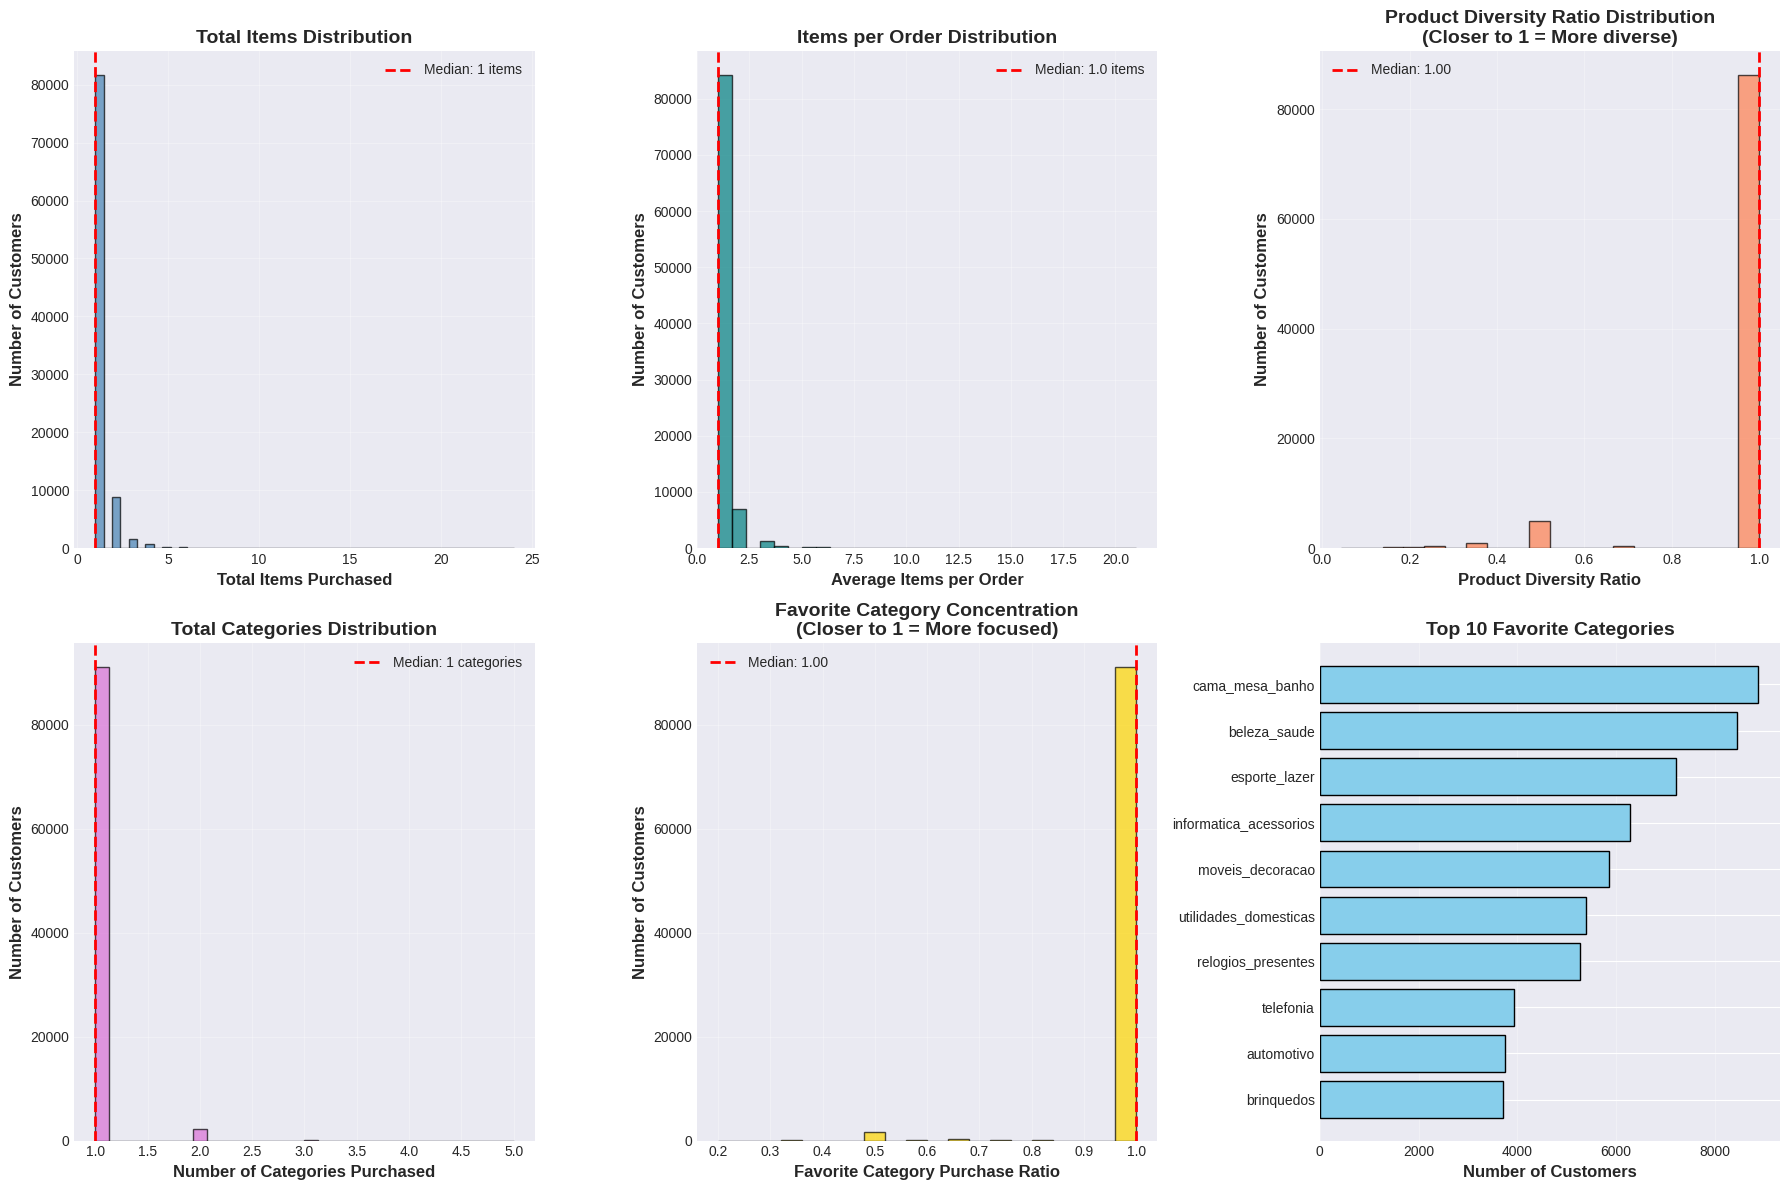

In [ ]:
# --------------------------------------------
# 3.8 시각화
# --------------------------------------------

print("\n" + "=" * 60)
print("Step 3: 시각화")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Total Items Distribution : 총 구매 품목 수 분포
# (의미: 고객들이 대체로 몇 개의 물건을 구매하는지 전체적인 규모 파악)
axes[0, 0].hist(product_features['total_items'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(product_features['total_items'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {product_features["total_items"].median():.0f} items')
axes[0, 0].set_xlabel('Total Items Purchased', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Total Items Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Items per Order Distribution : 주문당 평균 상품 수(Basket Size) 분포
# (의미: 한 번 결제할 때 낱개로 사는 편인지, 여러 개를 한꺼번에 담는 '대량 구매' 패턴인지 확인)
axes[0, 1].hist(product_features['items_per_order'], bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(product_features['items_per_order'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {product_features["items_per_order"].median():.1f} items')
axes[0, 1].set_xlabel('Average Items per Order', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Items per Order Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Product Diversity Ratio Distribution : 상품 다양성 비율 분포
# (의미: 1에 가까울수록 매번 '새로운 상품'을 구매함 vs 0에 가까울수록 '같은 상품'을 재구매함)
axes[0, 2].hist(product_features['product_diversity_ratio'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(product_features['product_diversity_ratio'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {product_features["product_diversity_ratio"].median():.2f}')
axes[0, 2].set_xlabel('Product Diversity Ratio', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Product Diversity Ratio Distribution\n(Closer to 1 = More diverse)', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(alpha=0.3)

# 4. Total Categories Distribution : 구매 카테고리 다양성 분포
# (의미: 고객이 얼마나 다양한 종류(Category)의 물건에 관심을 갖는지 파악 - Cross-selling 잠재력)
axes[1, 0].hist(product_features['total_categories'], bins=30, color='orchid', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(product_features['total_categories'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {product_features["total_categories"].median():.0f} categories')
axes[1, 0].set_xlabel('Number of Categories Purchased', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Total Categories Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# 5. Favorite Category Ratio Distribution : 최애 카테고리 집중도 분포
# (의미: 1에 가까울수록 특정 카테고리만 파는 '덕후'형 고객 vs 낮을수록 잡식성 쇼핑)
axes[1, 1].hist(product_features['favorite_category_ratio'], bins=20, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(product_features['favorite_category_ratio'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {product_features["favorite_category_ratio"].median():.2f}')
axes[1, 1].set_xlabel('Favorite Category Purchase Ratio', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Favorite Category Concentration\n(Closer to 1 = More focused)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

# 6. Top 10 Favorite Categories (Bar Chart) : 상위 10개 인기 카테고리
# (의미: 우리 고객들이 가장 많이 '주력'으로 삼는 카테고리가 무엇인지 시각화)
top_categories = product_features['favorite_category'].value_counts().head(10)
axes[1, 2].barh(range(len(top_categories)), top_categories.values, color='skyblue', edgecolor='black')
axes[1, 2].set_yticks(range(len(top_categories)))
axes[1, 2].set_yticklabels(top_categories.index, fontsize=10)
axes[1, 2].set_xlabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Top 10 Favorite Categories', fontsize=14, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------
# 3.9 RFM + Monetary + Product 병합
# --------------------------------------------

rfm_monetary_product = rfm_monetary.merge(product_features, on='customer_unique_id', how='left')

print(f"\n✅ RFM + Monetary + Product 병합 완료!")
print(f"   총 특성 수: {len(rfm_monetary_product.columns) - 1}개")
print(f"   특성 목록: {rfm_monetary_product.columns.tolist()}")


✅ RFM + Monetary + Product 병합 완료!
   총 특성 수: 22개
   특성 목록: ['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days', 'monetary', 'avg_order_value', 'min_order_value', 'max_order_value', 'avg_installments', 'max_installments', 'order_value_std', 'payment_type_most_common', 'credit_card_usage_ratio', 'total_items', 'unique_products', 'avg_item_price', 'total_item_price', 'items_per_order', 'product_diversity_ratio', 'total_categories', 'favorite_category', 'favorite_category_ratio', 'category_diversity']


In [ ]:
# --------------------------------------------
# 3.10 인사이트 도출
# --------------------------------------------

print("\n" + "=" * 60)
print("상품/카테고리 특성 인사이트")
print("=" * 60)

print(f"""
🛍️ 구매 패턴 분석:

1. 상품 구매량:
   - 주문당 평균 아이템: {product_features['items_per_order'].median():.1f}개 (중앙값)
   - 평균: {product_features['items_per_order'].mean():.1f}개

   💡 인사이트: {'고객들이 주로 단일 상품 구매' if product_features['items_per_order'].median() < 2 else '고객들이 여러 상품을 함께 구매'}

2. 상품 다양성:
   - 상품 다양성 비율 중앙값: {product_features['product_diversity_ratio'].median():.2f}
   - 평균 고유 상품 수: {product_features['unique_products'].mean():.1f}개

   💡 인사이트: {'대부분 같은 상품 반복 구매' if product_features['product_diversity_ratio'].median() < 0.5 else '다양한 상품 탐색'}

3. 카테고리 집중도:
   - 평균 구매 카테고리 수: {product_features['total_categories'].mean():.1f}개
   - 선호 카테고리 집중도: {product_features['favorite_category_ratio'].median():.2f}

   💡 인사이트: {'특정 카테고리에 집중' if product_features['favorite_category_ratio'].median() > 0.7 else '다양한 카테고리 구매'}

4. 인기 카테고리:
   - 가장 인기 있는 카테고리: {product_features['favorite_category'].mode()[0]}
   - 단일 카테고리만 구매하는 고객: {(product_features['total_categories'] == 1).sum():,}명 ({(product_features['total_categories'] == 1).sum() / len(product_features) * 100:.1f}%)

   💡 인사이트: {'대부분 고객이 특정 니즈로만 방문' if (product_features['total_categories'] == 1).sum() / len(product_features) > 0.7 else '고객들이 플랫폼을 다양하게 활용'}
""")

print("\n✅ Step 3 완료!")
print(f"현재까지 생성된 특성 수: {len(rfm_monetary_product.columns) - 1}개")
print("\n" + "=" * 60)
print("다음: Step 4 - 리뷰/만족도 특성 추가")
print("=" * 60)


상품/카테고리 특성 인사이트

🛍️ 구매 패턴 분석:

1. 상품 구매량:
   - 주문당 평균 아이템: 1.0개 (중앙값)
   - 평균: 1.1개

   💡 인사이트: 고객들이 주로 단일 상품 구매

2. 상품 다양성:
   - 상품 다양성 비율 중앙값: 1.00
   - 평균 고유 상품 수: 1.1개

   💡 인사이트: 다양한 상품 탐색

3. 카테고리 집중도:
   - 평균 구매 카테고리 수: 1.0개
   - 선호 카테고리 집중도: 1.00

   💡 인사이트: 특정 카테고리에 집중

4. 인기 카테고리:
   - 가장 인기 있는 카테고리: cama_mesa_banho
   - 단일 카테고리만 구매하는 고객: 91,088명 (97.6%)

   💡 인사이트: 대부분 고객이 특정 니즈로만 방문


✅ Step 3 완료!
현재까지 생성된 특성 수: 22개

다음: Step 4 - 리뷰/만족도 특성 추가


In [ ]:
# ============================================
# Step 4: Review/Satisfaction Features (리뷰/만족도 특성)
# ============================================
print("\n" + "=" * 60)
print("Step 4: 리뷰/만족도 특성 계산")
print("=" * 60)


Step 4: 리뷰/만족도 특성 계산


In [ ]:
# --------------------------------------------
# 4.0 이전 Step 특성 준비
# --------------------------------------------

print(f"✅ 현재까지 생성된 특성: {len(rfm_monetary_product.columns) - 1}개")
print(f"   특성 목록: {rfm_monetary_product.columns.tolist()}")

✅ 현재까지 생성된 특성: 22개
   특성 목록: ['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days', 'monetary', 'avg_order_value', 'min_order_value', 'max_order_value', 'avg_installments', 'max_installments', 'order_value_std', 'payment_type_most_common', 'credit_card_usage_ratio', 'total_items', 'unique_products', 'avg_item_price', 'total_item_price', 'items_per_order', 'product_diversity_ratio', 'total_categories', 'favorite_category', 'favorite_category_ratio', 'category_diversity']


In [ ]:
# --------------------------------------------
# 4.1 Reviews 데이터 준비
# --------------------------------------------

print("\n📋 Reviews 테이블 정보:")
print(f"총 리뷰 수: {len(reviews):,}")
print(f"컬럼: {reviews.columns.tolist()}")
print("\n샘플:")
print(reviews.head())


📋 Reviews 테이블 정보:
총 리뷰 수: 99,224
컬럼: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

샘플:
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  201

In [ ]:
# 리뷰 점수 분포 확인
print("\n📊 리뷰 점수 분포:")
print(reviews['review_score'].value_counts().sort_index())


📊 리뷰 점수 분포:
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64


In [ ]:
# 리뷰 결측치 확인
print("\n🔍 리뷰 결측치 확인:")
print(reviews.isnull().sum())


🔍 리뷰 결측치 확인:
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


In [ ]:
# --------------------------------------------
# 4.2 Reviews + Orders 조인 (customer_unique_id 매핑)
# --------------------------------------------

# Reviews에 customer_unique_id 추가
# orders_delivered에 customer_unique_id가 있음
reviews_customers = reviews.merge(
    orders_delivered[['order_id', 'customer_unique_id']],
    on='order_id',
    how='left'
)

print(f"\n✅ Reviews + Customer ID 매핑 완료:")
print(f"   총 행 수: {len(reviews_customers):,}")
print(f"   고유 고객 수: {reviews_customers['customer_unique_id'].nunique():,}")


✅ Reviews + Customer ID 매핑 완료:
   총 행 수: 99,224
   고유 고객 수: 92,755


In [ ]:
# --------------------------------------------
# 4.3 고객별 리뷰 특성 계산
# --------------------------------------------

print("\n" + "=" * 60)
print("고객별 리뷰 특성 집계 중...")
print("=" * 60)

# 리뷰 점수 집계
review_features = reviews_customers.groupby('customer_unique_id').agg({
    'review_score': [
        ('avg_review_score', 'mean'),        # 평균 리뷰 점수
        ('min_review_score', 'min'),         # 최저 리뷰 점수
        ('max_review_score', 'max'),         # 최고 리뷰 점수
        ('review_score_std', 'std')          # 리뷰 점수 표준편차
    ],
    'review_id': [
        ('total_reviews', 'count')           # 총 리뷰 작성 수
    ]
}).reset_index()

# 컬럼명 정리
review_features.columns = [
    'customer_unique_id',
    'avg_review_score',
    'min_review_score',
    'max_review_score',
    'review_score_std',
    'total_reviews'
]

# 리뷰 점수 표준편차 결측치 처리 (1개 리뷰만 있으면 std=NaN)
review_features['review_score_std'] = review_features['review_score_std'].fillna(0)

print(f"\n✅ 리뷰 점수 특성 계산 완료!")


고객별 리뷰 특성 집계 중...

✅ 리뷰 점수 특성 계산 완료!


In [ ]:
# --------------------------------------------
# 4.4 리뷰 작성 참여율 계산
# --------------------------------------------

# 전체 고객의 주문 수 (rfm의 frequency 활용)
# 리뷰 참여율 = 리뷰 작성 수 / 총 주문 수
review_participation = review_features.merge(
    rfm[['customer_unique_id', 'frequency']],
    on='customer_unique_id',
    how='left'
)

review_participation['review_participation_rate'] = review_participation['total_reviews'] / review_participation['frequency']

# frequency 컬럼 제거 (이미 rfm에 있음)
review_features = review_participation.drop('frequency', axis=1)

print(f"\n✅ 리뷰 참여율 계산 완료!")


✅ 리뷰 참여율 계산 완료!


In [ ]:
# --------------------------------------------
# 4.5 만족도 카테고리 분류
# --------------------------------------------

# 평균 리뷰 점수를 기준으로 만족도 그룹 분류
# 5점: 매우 만족, 4점: 만족, 3점: 보통, 1-2점: 불만족

def categorize_satisfaction(score):
    if pd.isna(score):
        return 'no_review'
    elif score >= 4.5:
        return 'very_satisfied'
    elif score >= 3.5:
        return 'satisfied'
    elif score >= 2.5:
        return 'neutral'
    else:
        return 'dissatisfied'

review_features['satisfaction_category'] = review_features['avg_review_score'].apply(categorize_satisfaction)

print(f"\n✅ 만족도 카테고리 분류 완료!")


✅ 만족도 카테고리 분류 완료!


In [ ]:
# --------------------------------------------
# 4.6 리뷰를 작성하지 않은 고객 처리
# --------------------------------------------

# 전체 고객 중 리뷰를 작성한 고객 수
customers_with_reviews = len(review_features)
total_customers = len(rfm)

print(f"\n📊 리뷰 작성 현황:")
print(f"   전체 고객 수: {total_customers:,}")
print(f"   리뷰 작성 고객: {customers_with_reviews:,} ({customers_with_reviews/total_customers*100:.1f}%)")
print(f"   리뷰 미작성 고객: {total_customers - customers_with_reviews:,} ({(total_customers - customers_with_reviews)/total_customers*100:.1f}%)")

# 리뷰 미작성 고객에 대한 기본값 설정 (나중에 병합할 때 처리)
# 일단 리뷰 작성한 고객만 review_features에 저장


📊 리뷰 작성 현황:
   전체 고객 수: 93,358
   리뷰 작성 고객: 92,755 (99.4%)
   리뷰 미작성 고객: 603 (0.6%)


In [ ]:
# --------------------------------------------
# 4.7 리뷰 특성 기본 통계
# --------------------------------------------

print("\n📊 리뷰 특성 기본 통계:")
print(review_features[['avg_review_score', 'total_reviews', 'review_participation_rate']].describe())


📊 리뷰 특성 기본 통계:
       avg_review_score  total_reviews  review_participation_rate
count      92755.000000   92755.000000               92755.000000
mean           4.153668       1.038877                   1.003026
std            1.280074       0.249410                   0.050550
min            1.000000       1.000000                   0.333333
25%            4.000000       1.000000                   1.000000
50%            5.000000       1.000000                   1.000000
75%            5.000000       1.000000                   1.000000
max            5.000000      15.000000                   2.000000


In [ ]:
# 만족도 카테고리 분포
print("\n📊 만족도 카테고리 분포:")
print(review_features['satisfaction_category'].value_counts())


📊 만족도 카테고리 분포:
satisfaction_category
very_satisfied    54782
satisfied         18412
dissatisfied      11773
neutral            7788
Name: count, dtype: int64


In [ ]:
# 가장 만족한 고객 TOP 10
print("\n🏆 가장 높은 평균 리뷰 점수 고객 TOP 10:")
satisfied_customers = review_features[review_features['total_reviews'] >= 2]  # 2개 이상 리뷰 작성한 고객
if len(satisfied_customers) > 0:
    print(satisfied_customers.nlargest(10, 'avg_review_score')[
        ['customer_unique_id', 'avg_review_score', 'total_reviews', 'satisfaction_category']
    ])


🏆 가장 높은 평균 리뷰 점수 고객 TOP 10:
                    customer_unique_id  avg_review_score  total_reviews  \
104   004288347e5e88a27ded2bb23747066c               5.0              2   
465   013ef03e0f3f408dd9bf555e4edcdc0a               5.0              2   
467   013f4353d26bb05dc6652f1269458d8d               5.0              2   
499   015557c9912277312b9073947804a7ba               5.0              2   
619   01a22e2079ea71e17313b88e5811e54a               5.0              2   
891   027803eb28cc01fbdf5da72b109fabee               5.0              2   
943   029b457bd01199c39136f89e0eddcd3a               5.0              2   
968   02b20b7c813efede140142ac610e36dc               5.0              2   
1092  02fbe4db886eb98774c8ba300d39fa79               5.0              3   
1169  032b3a42598667caf2e099999b9dc1b9               5.0              2   

     satisfaction_category  
104         very_satisfied  
465         very_satisfied  
467         very_satisfied  
499         very_satisfied  


In [ ]:
# 가장 불만족한 고객 TOP 10
print("\n📉 가장 낮은 평균 리뷰 점수 고객 TOP 10:")
if len(satisfied_customers) > 0:
    print(satisfied_customers.nsmallest(10, 'avg_review_score')[
        ['customer_unique_id', 'avg_review_score', 'total_reviews', 'satisfaction_category']
    ])


📉 가장 낮은 평균 리뷰 점수 고객 TOP 10:
                    customer_unique_id  avg_review_score  total_reviews  \
2217  0621c2a5979d3e887ae519620cbe2926               1.0              2   
3173  089bc915af34d9041b3a88a1aa84292b               1.0              2   
3954  0aadc1d26d1c8b88a52c39a533ccea93               1.0              2   
6047  10867a902e32dd54061b2cda9c55b0b6               1.0              2   
6802  12ab9334b1240d6d037f2b0102a49571               1.0              2   
7185  13aec51202205c662b24202760e93a92               1.0              2   
7519  14843983d4a159080f6afe4b7f346e7c               1.0              3   
8112  1605a6c5d93d3488fb621c5323930795               1.0              2   
8591  1772d62f5099be6942fbb3d3e881cc7c               1.0              2   
9908  1b270bd97f6e1d9af2d5d06f0d4a80e8               1.0              2   

     satisfaction_category  
2217          dissatisfied  
3173          dissatisfied  
3954          dissatisfied  
6047          dissatisfied  



Step 4: 시각화


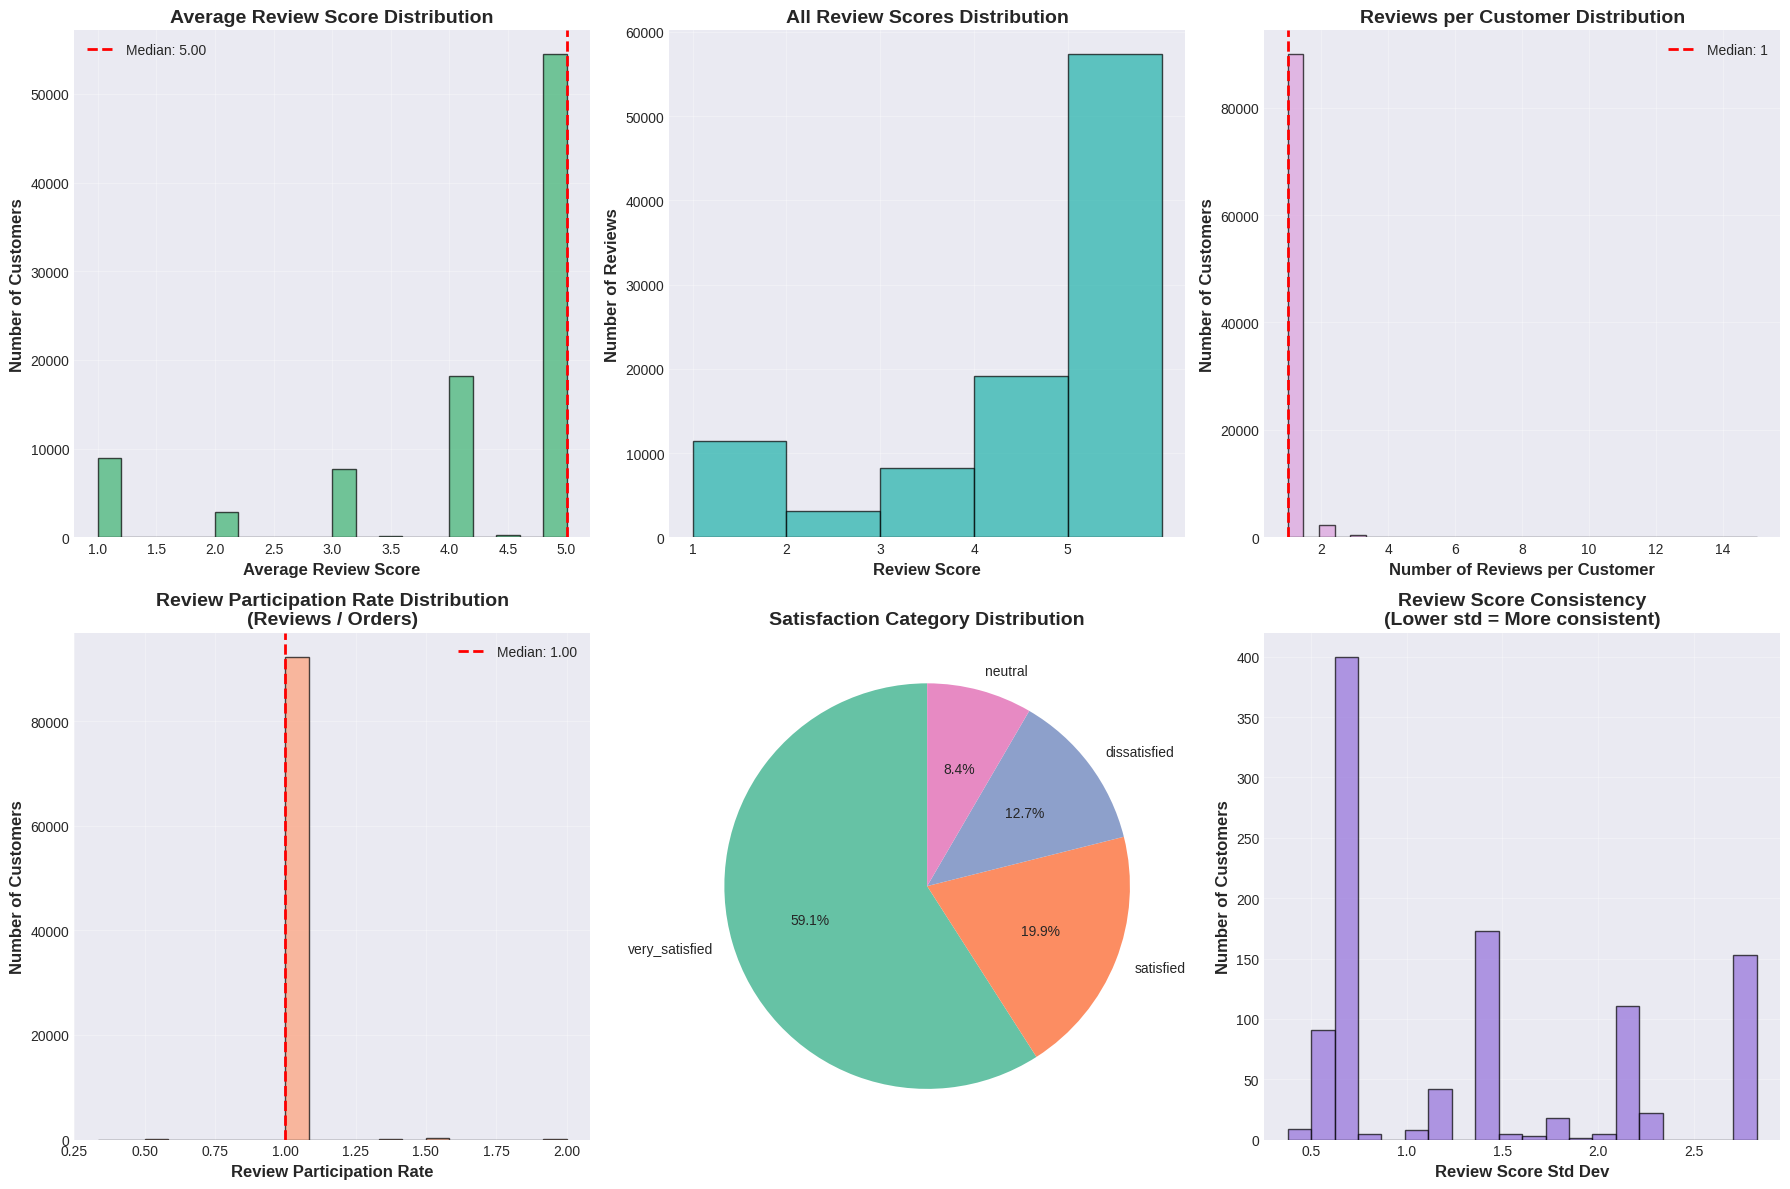

In [ ]:
# --------------------------------------------
# 4.8 시각화
# --------------------------------------------

print("\n" + "=" * 60)
print("Step 4: 시각화")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Average Review Score Distribution : 고객별 평균 평점 분포
# (의미: 고객 한 명, 한 명의 평균적인 만족도 레벨을 확인합니다.
#        왼쪽(1~2점)에 봉우리가 있다면, 습관적으로 불만을 표출하는 블랙 컨슈머군이 있는지 의심해볼 수 있습니다.)
axes[0, 0].hist(review_features['avg_review_score'], bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(review_features['avg_review_score'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {review_features["avg_review_score"].median():.2f}')
axes[0, 0].set_xlabel('Average Review Score', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Average Review Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Review Score Distribution (All Reviews) : 전체 리뷰 점수 분포 (개별 건수 기준)
# (의미: 고객 단위가 아니라, 시스템 전체에 쌓인 리뷰의 점수 분포를 봅니다.
#        Olist 데이터는 보통 5점이 압도적으로 많고 1점이 그 다음으로 많은 'U자형' 혹은 'J자형' 분포를 보입니다.)
axes[0, 1].hist(reviews_customers['review_score'], bins=5, color='lightseagreen', edgecolor='black', alpha=0.7,
                range=(1, 6))
axes[0, 1].set_xlabel('Review Score', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
axes[0, 1].set_title('All Review Scores Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks([1, 2, 3, 4, 5])
axes[0, 1].grid(alpha=0.3)

# 3. Total Reviews per Customer Distribution : 고객당 작성 리뷰 수 분포
# (의미: 고객이 우리 서비스와 얼마나 적극적으로 소통하는지(Engagement) 보여줍니다.
#        리뷰를 많이 남기는 고객은 충성 고객일 수도 있지만, 불만이 많아 컴플레인을 자주 거는 고객일 수도 있습니다.)
axes[0, 2].hist(review_features['total_reviews'], bins=30, color='plum', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(review_features['total_reviews'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {review_features["total_reviews"].median():.0f}')
axes[0, 2].set_xlabel('Number of Reviews per Customer', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Reviews per Customer Distribution', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(alpha=0.3)

# 4. Review Participation Rate Distribution : 리뷰 참여율 분포 (작성 리뷰 수 / 주문 수)
# (의미: 물건을 사고 나서 피드백을 남기는 확률입니다.
#        1.0(100%)인 고객은 자신의 경험을 공유하려는 의지가 매우 강한 '적극적 참여자'입니다.)
axes[1, 0].hist(review_features['review_participation_rate'], bins=20, color='lightsalmon', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(review_features['review_participation_rate'].median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {review_features["review_participation_rate"].median():.2f}')
axes[1, 0].set_xlabel('Review Participation Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Review Participation Rate Distribution\n(Reviews / Orders)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# 5. Satisfaction Category Distribution (Pie Chart) : 만족도 카테고리 비율
# (의미: 고객들을 NPS(순추천지수)처럼 그룹화했을 때, 우리 서비스의 '찐팬(Promoter)'과 '안티(Detractor)' 비율이 어느 정도인지 한눈에 파악합니다.)
satisfaction_counts = review_features['satisfaction_category'].value_counts()
axes[1, 1].pie(satisfaction_counts.values, labels=satisfaction_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set2", len(satisfaction_counts)))
axes[1, 1].set_title('Satisfaction Category Distribution', fontsize=14, fontweight='bold')

# 6. Review Score Std Distribution : 리뷰 점수 표준편차(일관성) 분포
# (의미: 표준편차가 낮으면(0에 가까움) 항상 비슷한 점수를 주는 '일관된 고객'이고,
#        높으면 기분에 따라 1점과 5점을 오가는 '변덕스러운(또는 서비스 품질에 민감한) 고객'입니다.)
axes[1, 2].hist(review_features[review_features['review_score_std'] > 0]['review_score_std'],
                bins=20, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Review Score Std Dev', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Review Score Consistency\n(Lower std = More consistent)', fontsize=14, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------
# 4.9 모든 특성 병합 (리뷰 미작성 고객 포함)
# --------------------------------------------

# RFM + Monetary + Product에 Review 특성 병합
# left join으로 리뷰 없는 고객도 포함
all_features = rfm_monetary_product.merge(review_features, on='customer_unique_id', how='left')

# 리뷰 미작성 고객의 결측치 처리
# 리뷰 점수는 평균값으로 대체하지 않고, 별도 표시
all_features['avg_review_score'] = all_features['avg_review_score'].fillna(0)  # 0 = 리뷰 없음
all_features['min_review_score'] = all_features['min_review_score'].fillna(0)
all_features['max_review_score'] = all_features['max_review_score'].fillna(0)
all_features['review_score_std'] = all_features['review_score_std'].fillna(0)
all_features['total_reviews'] = all_features['total_reviews'].fillna(0)
all_features['review_participation_rate'] = all_features['review_participation_rate'].fillna(0)
all_features['satisfaction_category'] = all_features['satisfaction_category'].fillna('no_review')

print(f"\n✅ 모든 특성 병합 완료!")
print(f"   총 고객 수: {len(all_features):,}")
print(f"   총 특성 수: {len(all_features.columns) - 1}개")
print(f"   특성 목록: {all_features.columns.tolist()}")


✅ 모든 특성 병합 완료!
   총 고객 수: 93,358
   총 특성 수: 29개
   특성 목록: ['customer_unique_id', 'recency', 'frequency', 'customer_lifetime_days', 'monetary', 'avg_order_value', 'min_order_value', 'max_order_value', 'avg_installments', 'max_installments', 'order_value_std', 'payment_type_most_common', 'credit_card_usage_ratio', 'total_items', 'unique_products', 'avg_item_price', 'total_item_price', 'items_per_order', 'product_diversity_ratio', 'total_categories', 'favorite_category', 'favorite_category_ratio', 'category_diversity', 'avg_review_score', 'min_review_score', 'max_review_score', 'review_score_std', 'total_reviews', 'review_participation_rate', 'satisfaction_category']


In [ ]:
# --------------------------------------------
# 4.10 인사이트 도출
# --------------------------------------------

print("\n" + "=" * 60)
print("리뷰/만족도 특성 인사이트")
print("=" * 60)

print(f"""
⭐ 고객 만족도 분석:

1. 전반적인 만족도:
   - 평균 리뷰 점수 (리뷰 작성 고객): {review_features['avg_review_score'].mean():.2f}점
   - 중앙값: {review_features['avg_review_score'].median():.2f}점

   💡 인사이트: {'전반적으로 높은 만족도' if review_features['avg_review_score'].mean() >= 4 else '만족도 개선 필요'}

2. 리뷰 참여율:
   - 리뷰 작성 고객 비율: {customers_with_reviews/total_customers*100:.1f}%
   - 평균 리뷰 참여율 (작성 고객 기준): {review_features['review_participation_rate'].mean()*100:.1f}%

   💡 인사이트: {'리뷰 참여도가 낮음, 리뷰 독려 필요' if customers_with_reviews/total_customers < 0.3 else '리뷰 참여도 양호'}

3. 만족도 분포:
   - 매우 만족 (4.5+): {(review_features['satisfaction_category'] == 'very_satisfied').sum():,}명 ({(review_features['satisfaction_category'] == 'very_satisfied').sum()/len(review_features)*100:.1f}%)
   - 만족 (3.5-4.5): {(review_features['satisfaction_category'] == 'satisfied').sum():,}명 ({(review_features['satisfaction_category'] == 'satisfied').sum()/len(review_features)*100:.1f}%)
   - 보통 (2.5-3.5): {(review_features['satisfaction_category'] == 'neutral').sum():,}명 ({(review_features['satisfaction_category'] == 'neutral').sum()/len(review_features)*100:.1f}%)
   - 불만족 (<2.5): {(review_features['satisfaction_category'] == 'dissatisfied').sum():,}명 ({(review_features['satisfaction_category'] == 'dissatisfied').sum()/len(review_features)*100:.1f}%)

4. 리뷰 일관성:
   - 평균 리뷰 점수 표준편차: {review_features[review_features['review_score_std'] > 0]['review_score_std'].mean():.2f}

   💡 인사이트: {'대부분 고객이 일관된 만족도 유지' if review_features[review_features['review_score_std'] > 0]['review_score_std'].mean() < 1 else '고객 경험이 일관되지 않음'}
""")

print("\n✅ Step 4 완료!")
print(f"현재까지 생성된 특성 수: {len(all_features.columns) - 1}개")
print("\n" + "=" * 60)
print("다음: Step 5 - 데이터 전처리 및 정제")
print("=" * 60)


리뷰/만족도 특성 인사이트

⭐ 고객 만족도 분석:

1. 전반적인 만족도:
   - 평균 리뷰 점수 (리뷰 작성 고객): 4.15점
   - 중앙값: 5.00점

   💡 인사이트: 전반적으로 높은 만족도

2. 리뷰 참여율:
   - 리뷰 작성 고객 비율: 99.4%
   - 평균 리뷰 참여율 (작성 고객 기준): 100.3%

   💡 인사이트: 리뷰 참여도 양호

3. 만족도 분포:
   - 매우 만족 (4.5+): 54,782명 (59.1%)
   - 만족 (3.5-4.5): 18,412명 (19.9%)
   - 보통 (2.5-3.5): 7,788명 (8.4%)
   - 불만족 (<2.5): 11,773명 (12.7%)

4. 리뷰 일관성:
   - 평균 리뷰 점수 표준편차: 1.36

   💡 인사이트: 고객 경험이 일관되지 않음


✅ Step 4 완료!
현재까지 생성된 특성 수: 29개

다음: Step 5 - 데이터 전처리 및 정제


In [ ]:
# ============================================
# Step 5: Data Preprocessing (데이터 전처리 및 정제)
# ============================================

print("\n" + "=" * 60)
print("Step 5: 데이터 전처리 및 정제")
print("=" * 60)


Step 5: 데이터 전처리 및 정제


In [ ]:
# --------------------------------------------
# 5.0 현재 데이터 상태 확인
# --------------------------------------------

print(f"✅ 현재 데이터 상태:")
print(f"   총 고객 수: {len(all_features):,}")
print(f"   총 특성 수: {len(all_features.columns) - 1}개")
print(f"\n특성 목록:")
for i, col in enumerate(all_features.columns, 1):
    print(f"   {i}. {col}")

✅ 현재 데이터 상태:
   총 고객 수: 93,358
   총 특성 수: 29개

특성 목록:
   1. customer_unique_id
   2. recency
   3. frequency
   4. customer_lifetime_days
   5. monetary
   6. avg_order_value
   7. min_order_value
   8. max_order_value
   9. avg_installments
   10. max_installments
   11. order_value_std
   12. payment_type_most_common
   13. credit_card_usage_ratio
   14. total_items
   15. unique_products
   16. avg_item_price
   17. total_item_price
   18. items_per_order
   19. product_diversity_ratio
   20. total_categories
   21. favorite_category
   22. favorite_category_ratio
   23. category_diversity
   24. avg_review_score
   25. min_review_score
   26. max_review_score
   27. review_score_std
   28. total_reviews
   29. review_participation_rate
   30. satisfaction_category


In [ ]:
# --------------------------------------------
# 5.1 결측치 확인 및 처리
# --------------------------------------------

print("\n" + "=" * 60)
print("5.1 결측치 확인 및 처리")
print("=" * 60)


5.1 결측치 확인 및 처리


In [ ]:
# 결측치 확인
missing_values = all_features.isnull().sum()
missing_percent = (missing_values / len(all_features)) * 100

missing_df = pd.DataFrame({
    '결측치 개수': missing_values,
    '결측치 비율(%)': missing_percent
})

print("\n📊 결측치 현황:")
print(missing_df[missing_df['결측치 개수'] > 0])

if missing_df[missing_df['결측치 개수'] > 0].empty:
    print("✅ 결측치 없음!")
else:
    print("\n⚠️ 결측치 처리 중...")
    # 수치형 컬럼의 결측치는 0으로 처리 (이미 대부분 처리됨)
    numeric_columns = all_features.select_dtypes(include=[np.number]).columns
    all_features[numeric_columns] = all_features[numeric_columns].fillna(0)
    print("✅ 수치형 결측치 처리 완료!")


📊 결측치 현황:
                  결측치 개수  결측치 비율(%)
avg_order_value        1   0.001071
min_order_value        1   0.001071
max_order_value        1   0.001071
avg_installments       1   0.001071
max_installments       1   0.001071

⚠️ 결측치 처리 중...
✅ 수치형 결측치 처리 완료!


In [ ]:
# --------------------------------------------
# 5.2 데이터 타입 확인
# --------------------------------------------

print("\n" + "=" * 60)
print("5.2 데이터 타입 확인")
print("=" * 60)

print("\n📊 데이터 타입별 컬럼 수:")
print(all_features.dtypes.value_counts())

# 범주형 변수 확인
categorical_columns = all_features.select_dtypes(include=['object']).columns.tolist()
if 'customer_unique_id' in categorical_columns:
    categorical_columns.remove('customer_unique_id')  # ID는 제외

print(f"\n📋 범주형 변수: {categorical_columns}")


5.2 데이터 타입 확인

📊 데이터 타입별 컬럼 수:
float64    20
int64       6
object      4
Name: count, dtype: int64

📋 범주형 변수: ['payment_type_most_common', 'favorite_category', 'satisfaction_category']


In [ ]:
# --------------------------------------------
# 5.3 범주형 변수 인코딩
# --------------------------------------------

print("\n" + "=" * 60)
print("5.3 범주형 변수 인코딩")
print("=" * 60)

# 범주형 변수들:
# 1. payment_type_most_common
# 2. favorite_category
# 3. satisfaction_category

# 인코딩 전 데이터 백업
all_features_encoded = all_features.copy()

# Label Encoding vs One-Hot Encoding 결정
# - 카테고리가 많으면 (>10) Label Encoding
# - 카테고리가 적으면 (<=10) One-Hot Encoding


5.3 범주형 변수 인코딩


In [ ]:
for col in categorical_columns:
    unique_values = all_features_encoded[col].nunique()
    print(f"\n'{col}' 처리 중...")
    print(f"   고유값 개수: {unique_values}")

    if unique_values > 10:
        # Label Encoding (카테고리가 많을 때)
        print(f"   → Label Encoding 적용")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        all_features_encoded[f'{col}_encoded'] = le.fit_transform(all_features_encoded[col].astype(str))
        # 원본 컬럼은 나중에 해석용으로 보관

    else:
        # One-Hot Encoding (카테고리가 적을 때)
        print(f"   → One-Hot Encoding 적용")
        print(f"   카테고리: {all_features_encoded[col].unique()[:5]}...")  # 처음 5개만 출력
        dummies = pd.get_dummies(all_features_encoded[col], prefix=col, drop_first=True)
        all_features_encoded = pd.concat([all_features_encoded, dummies], axis=1)

print("\n✅ 범주형 변수 인코딩 완료!")


'payment_type_most_common' 처리 중...
   고유값 개수: 5
   → One-Hot Encoding 적용
   카테고리: ['credit_card' 'boleto' 'debit_card' 'voucher' 'unknown']...

'favorite_category' 처리 중...
   고유값 개수: 74
   → Label Encoding 적용

'satisfaction_category' 처리 중...
   고유값 개수: 5
   → One-Hot Encoding 적용
   카테고리: ['very_satisfied' 'satisfied' 'neutral' 'dissatisfied' 'no_review']...

✅ 범주형 변수 인코딩 완료!


In [ ]:
# --------------------------------------------
# 5.4 Clustering용 데이터셋 준비
# --------------------------------------------

print("\n" + "=" * 60)
print("5.4 Clustering용 데이터셋 준비")
print("=" * 60)

# Clustering에 사용할 컬럼 선택
# 제외할 컬럼:
# - customer_unique_id (ID)
# - 원본 범주형 변수 (인코딩된 버전 사용)
# - 날짜 관련 (last_purchase_date, first_purchase_date)

exclude_columns = ['customer_unique_id', 'last_purchase_date', 'first_purchase_date']
exclude_columns.extend(categorical_columns)  # 원본 범주형 변수 제외

# Clustering 특성만 선택
clustering_features = all_features_encoded.drop(columns=exclude_columns, errors='ignore')

print(f"\n✅ Clustering용 특성 선택 완료!")
print(f"   사용할 특성 수: {len(clustering_features.columns)}개")
print(f"   특성 목록:")
for i, col in enumerate(clustering_features.columns, 1):
    print(f"   {i}. {col}")


5.4 Clustering용 데이터셋 준비

✅ Clustering용 특성 선택 완료!
   사용할 특성 수: 35개
   특성 목록:
   1. recency
   2. frequency
   3. customer_lifetime_days
   4. monetary
   5. avg_order_value
   6. min_order_value
   7. max_order_value
   8. avg_installments
   9. max_installments
   10. order_value_std
   11. credit_card_usage_ratio
   12. total_items
   13. unique_products
   14. avg_item_price
   15. total_item_price
   16. items_per_order
   17. product_diversity_ratio
   18. total_categories
   19. favorite_category_ratio
   20. category_diversity
   21. avg_review_score
   22. min_review_score
   23. max_review_score
   24. review_score_std
   25. total_reviews
   26. review_participation_rate
   27. payment_type_most_common_credit_card
   28. payment_type_most_common_debit_card
   29. payment_type_most_common_unknown
   30. payment_type_most_common_voucher
   31. favorite_category_encoded
   32. satisfaction_category_neutral
   33. satisfaction_category_no_review
   34. satisfaction_category_satis

In [ ]:
# --------------------------------------------
# 5.5 이상치(Outlier) 확인
# --------------------------------------------

print("\n" + "=" * 60)
print("5.5 이상치(Outlier) 확인")
print("=" * 60)

# 주요 특성의 이상치 확인 (IQR 방법)
key_features = ['recency', 'frequency', 'monetary', 'avg_order_value', 'total_items']

outlier_summary = {}

for feature in key_features:
    if feature in clustering_features.columns:
        Q1 = clustering_features[feature].quantile(0.25)
        Q3 = clustering_features[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((clustering_features[feature] < lower_bound) |
                   (clustering_features[feature] > upper_bound)).sum()

        outlier_summary[feature] = {
            '하한선': lower_bound,
            '상한선': upper_bound,
            '이상치 개수': outliers,
            '이상치 비율(%)': (outliers / len(clustering_features)) * 100
        }

print("\n📊 주요 특성의 이상치 현황:")
outlier_df = pd.DataFrame(outlier_summary).T
print(outlier_df)


5.5 이상치(Outlier) 확인

📊 주요 특성의 이상치 현황:
                       하한선        상한선   이상치 개수  이상치 비율(%)
recency         -235.00000  693.00000     26.0   0.027850
frequency          1.00000    1.00000   2801.0   3.000278
monetary        -116.20500  361.81500   7402.0   7.928619
avg_order_value -110.02625  345.24375   7281.0   7.799010
total_items        1.00000    1.00000  11610.0  12.435999


In [ ]:
# 이상치 처리 방법 결정
print("\n🤔 이상치 처리 방법:")
print("""
1. 제거: 이상치를 완전히 제거 (데이터 손실)
2. 캡핑(Capping): 이상치를 상/하한선으로 대체
3. 유지: 이상치도 의미 있는 데이터로 간주 (추천!)

→ 이커머스 데이터에서 '고액 구매 고객'은 이상치지만 중요한 그룹!
→ Hierarchical Clustering은 이상치에 민감하지 않으므로 유지!
""")

print("✅ 이상치는 유지하기로 결정 (중요한 고객 세그먼트일 수 있음)")


🤔 이상치 처리 방법:

1. 제거: 이상치를 완전히 제거 (데이터 손실)
2. 캡핑(Capping): 이상치를 상/하한선으로 대체
3. 유지: 이상치도 의미 있는 데이터로 간주 (추천!)

→ 이커머스 데이터에서 '고액 구매 고객'은 이상치지만 중요한 그룹!
→ Hierarchical Clustering은 이상치에 민감하지 않으므로 유지!

✅ 이상치는 유지하기로 결정 (중요한 고객 세그먼트일 수 있음)


In [ ]:
# --------------------------------------------
# 5.6 스케일링 (Standardization)
# --------------------------------------------

print("\n" + "=" * 60)
print("5.6 스케일링 (Standardization)")
print("=" * 60)

print("""
🤔 왜 스케일링이 필요한가?
   - Hierarchical Clustering은 거리(distance) 기반 알고리즘
   - 스케일이 다른 변수들이 섞이면 큰 값이 지배
   - 예: monetary(0~100,000) vs review_score(0~5)
        → monetary만 보고 군집화됨!

📊 스케일링 방법:
   - StandardScaler: 평균 0, 표준편차 1로 변환
   - 모든 변수를 동등한 '중요도'로 만듦
""")


5.6 스케일링 (Standardization)

🤔 왜 스케일링이 필요한가?
   - Hierarchical Clustering은 거리(distance) 기반 알고리즘
   - 스케일이 다른 변수들이 섞이면 큰 값이 지배
   - 예: monetary(0~100,000) vs review_score(0~5)
        → monetary만 보고 군집화됨!

📊 스케일링 방법:
   - StandardScaler: 평균 0, 표준편차 1로 변환
   - 모든 변수를 동등한 '중요도'로 만듦



In [ ]:
from sklearn.preprocessing import StandardScaler

# 스케일러 생성
scaler = StandardScaler()

# 스케일링 전 통계
print("\n📊 스케일링 전 주요 특성 통계:")
print(clustering_features[key_features].describe())

# 스케일링 적용
clustering_features_scaled = scaler.fit_transform(clustering_features)

# DataFrame으로 변환 (컬럼명 유지)
clustering_features_scaled_df = pd.DataFrame(
    clustering_features_scaled,
    columns=clustering_features.columns,
    index=clustering_features.index
)


📊 스케일링 전 주요 특성 통계:
            recency     frequency      monetary  avg_order_value   total_items
count  93358.000000  93358.000000  93358.000000     93358.000000  93358.000000
mean     236.941773      1.033420    165.197003       157.651833      1.180370
std      152.591453      0.209097    226.314012       216.870374      0.620857
min        0.000000      1.000000      0.000000         0.000000      1.000000
25%      113.000000      1.000000     63.052500        60.700000      1.000000
50%      218.000000      1.000000    107.780000       103.550000      1.000000
75%      345.000000      1.000000    182.557500       174.517500      1.000000
max      713.000000     15.000000  13664.080000     13664.080000     24.000000


In [ ]:
# 스케일링 후 통계
print("\n📊 스케일링 후 주요 특성 통계:")
print(clustering_features_scaled_df[key_features].describe())

print("\n✅ 스케일링 완료!")
print(f"   평균: 약 0, 표준편차: 약 1로 변환됨")


📊 스케일링 후 주요 특성 통계:
            recency     frequency      monetary  avg_order_value   total_items
count  9.335800e+04  9.335800e+04  9.335800e+04     9.335800e+04  9.335800e+04
mean  -2.374615e-17 -4.794896e-17  1.412592e-16    -9.818121e-17  7.040125e-17
std    1.000005e+00  1.000005e+00  1.000005e+00     1.000005e+00  1.000005e+00
min   -1.552794e+00 -1.598294e-01 -7.299499e-01    -7.269443e-01 -2.905195e-01
25%   -8.122502e-01 -1.598294e-01 -4.513421e-01    -4.470521e-01 -2.905195e-01
50%   -1.241346e-01 -1.598294e-01 -2.537064e-01    -2.494676e-01 -2.905195e-01
75%    7.081577e-01 -1.598294e-01  7.671019e-02     7.776884e-02 -2.905195e-01
max    3.119839e+00  6.679496e+01  5.964701e+01     6.227914e+01  3.675523e+01

✅ 스케일링 완료!
   평균: 약 0, 표준편차: 약 1로 변환됨


In [ ]:
# --------------------------------------------
# 5.7 최종 데이터셋 확인
# --------------------------------------------

print("\n" + "=" * 60)
print("5.7 최종 데이터셋 확인")
print("=" * 60)

print(f"\n✅ 최종 Clustering 데이터셋:")
print(f"   고객 수: {len(clustering_features_scaled_df):,}")
print(f"   특성 수: {len(clustering_features_scaled_df.columns)}개")
print(f"   데이터 크기: {clustering_features_scaled_df.shape}")

print("\n📊 최종 데이터 샘플 (처음 5행):")
print(clustering_features_scaled_df.head())


5.7 최종 데이터셋 확인

✅ 최종 Clustering 데이터셋:
   고객 수: 93,358
   특성 수: 35개
   데이터 크기: (93358, 35)

📊 최종 데이터 샘플 (처음 5행):
    recency  frequency  customer_lifetime_days  monetary  avg_order_value  \
0 -0.825357  -0.159829               -0.105548 -0.102942        -0.072633   
1 -0.805697  -0.159829               -0.105548 -0.609806        -0.601569   
2  1.959873  -0.159829               -0.105548 -0.348973        -0.329377   
3  0.544321  -0.159829               -0.105548 -0.537208        -0.525809   
4  0.328056  -0.159829               -0.105548  0.140041         0.180930   

   min_order_value  max_order_value  avg_installments  max_installments  \
0        -0.061279        -0.083627          1.906364          1.859946   
1        -0.591679        -0.605789         -0.709854         -0.712233   
2        -0.318734        -0.337084          1.906364          1.859946   
3        -0.515710        -0.531000          0.411382          0.390129   
4         0.192986         0.166688          1.15


5.8 특성 간 상관관계 분석

⚠️ 높은 상관관계 (>0.9) 특성 쌍:
                        특성1                                   특성2      상관계수
0                  monetary                       avg_order_value  0.975295
1                  monetary                       min_order_value  0.953696
2                  monetary                       max_order_value  0.987734
3                  monetary                        avg_item_price  0.903721
4                  monetary                      total_item_price  0.995805
5           avg_order_value                       min_order_value  0.995078
6           avg_order_value                       max_order_value  0.994716
7           avg_order_value                        avg_item_price  0.912908
8           avg_order_value                      total_item_price  0.973949
9           min_order_value                       max_order_value  0.979872
10          min_order_value                        avg_item_price  0.901482
11          min_order_value                  

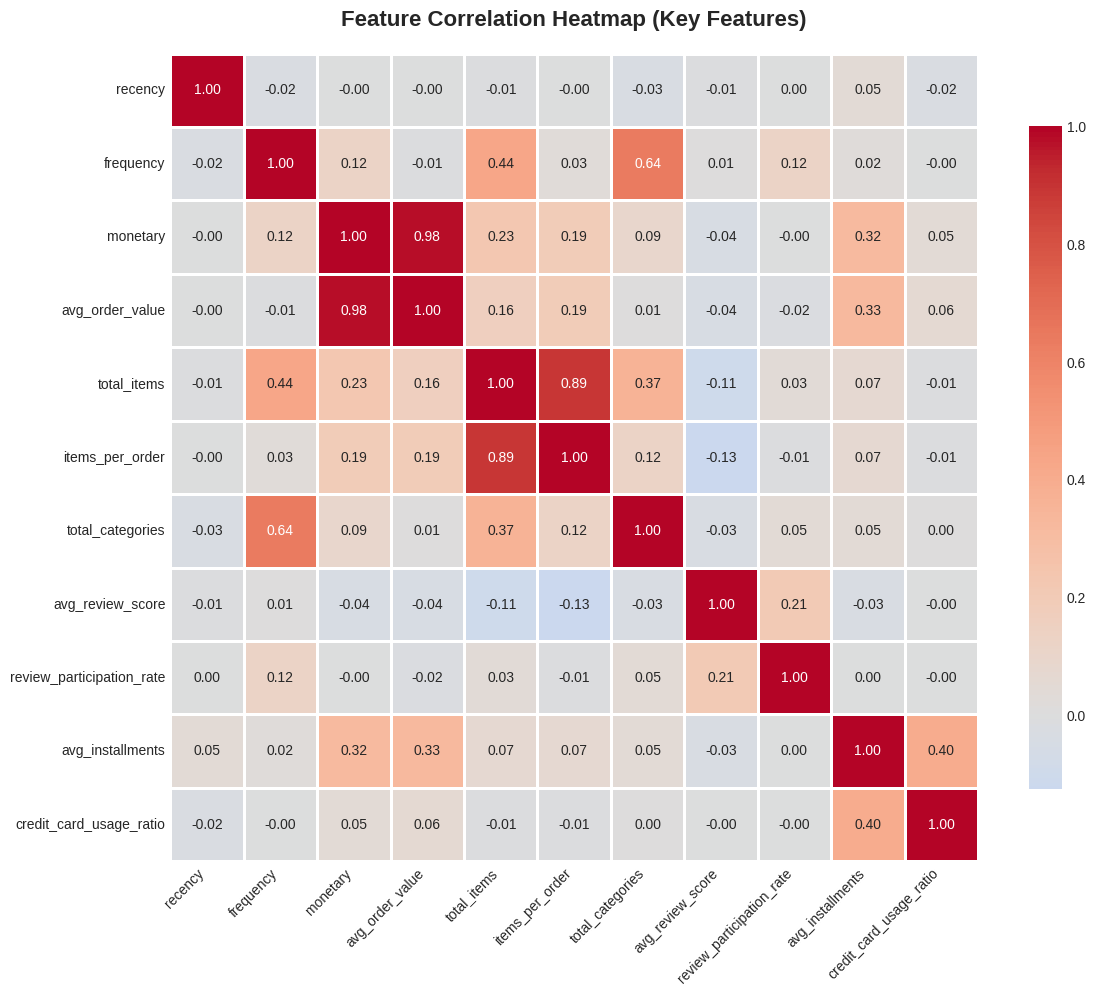

In [ ]:
# --------------------------------------------
# 5.8 상관관계 분석
# --------------------------------------------

print("\n" + "=" * 60)
print("5.8 특성 간 상관관계 분석")
print("=" * 60)

# 상관관계가 매우 높은 특성 쌍 찾기 (다중공선성 확인)
correlation_matrix = clustering_features_scaled_df.corr()

# 상관계수 > 0.9인 쌍 찾기 (자기 자신 제외)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                '특성1': correlation_matrix.columns[i],
                '특성2': correlation_matrix.columns[j],
                '상관계수': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️ 높은 상관관계 (>0.9) 특성 쌍:")
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df)
    print("\n💡 이런 특성들은 서로 비슷한 정보를 제공하므로, 필요시 하나만 선택 가능")
else:
    print("\n✅ 높은 상관관계(>0.9)를 가진 특성 쌍 없음!")

# 상관관계 히트맵 (주요 특성만)
print("\n📊 주요 특성 간 상관관계 히트맵 생성 중...")

# 주요 특성만 선택 (너무 많으면 보기 어려움)
important_features = ['recency', 'frequency', 'monetary', 'avg_order_value',
                     'total_items', 'items_per_order', 'total_categories',
                     'avg_review_score', 'review_participation_rate',
                     'avg_installments', 'credit_card_usage_ratio']

# 실제 존재하는 특성만 필터링
important_features = [f for f in important_features if f in clustering_features_scaled_df.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(clustering_features_scaled_df[important_features].corr(),
            annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (Key Features)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------
# 5.9 데이터 저장
# --------------------------------------------

print("\n" + "=" * 60)
print("5.9 데이터 저장")
print("=" * 60)

# Clustering에 사용할 최종 데이터
final_clustering_data = clustering_features_scaled_df.copy()

# 해석을 위한 원본 데이터 (customer_id 포함)
final_original_data = all_features_encoded.copy()

print(f"\n✅ 데이터 저장 완료!")
print(f"   - final_clustering_data: Clustering용 (스케일링됨)")
print(f"   - final_original_data: 해석용 (원본 값)")


5.9 데이터 저장

✅ 데이터 저장 완료!
   - final_clustering_data: Clustering용 (스케일링됨)
   - final_original_data: 해석용 (원본 값)


In [ ]:
# --------------------------------------------
# 5.10 Step 5 요약
# --------------------------------------------

print("\n" + "=" * 60)
print("Step 5 완료 요약")
print("=" * 60)

print(f"""
✅ 전처리 완료 사항:

1. 결측치 처리: 완료
2. 범주형 변수 인코딩: 완료
   - Label Encoding: {[col for col in categorical_columns if all_features_encoded[col].nunique() > 10]}
   - One-Hot Encoding: {[col for col in categorical_columns if all_features_encoded[col].nunique() <= 10]}

3. 이상치 처리: 유지 (중요한 세그먼트)
4. 스케일링: StandardScaler 적용
5. 상관관계 분석: 완료

📊 최종 데이터:
   - 고객 수: {len(final_clustering_data):,}
   - 특성 수: {len(final_clustering_data.columns)}개
   - 모든 특성이 평균 0, 표준편차 1로 표준화됨

🎯 다음 단계:
   Step 6에서 Hierarchical Clustering 적용!
""")

print("\n" + "=" * 60)
print("다음: Step 6 - Hierarchical Clustering 적용")
print("=" * 60)


Step 5 완료 요약

✅ 전처리 완료 사항:

1. 결측치 처리: 완료
2. 범주형 변수 인코딩: 완료
   - Label Encoding: ['favorite_category']
   - One-Hot Encoding: ['payment_type_most_common', 'satisfaction_category']

3. 이상치 처리: 유지 (중요한 세그먼트)
4. 스케일링: StandardScaler 적용
5. 상관관계 분석: 완료

📊 최종 데이터:
   - 고객 수: 93,358
   - 특성 수: 35개
   - 모든 특성이 평균 0, 표준편차 1로 표준화됨

🎯 다음 단계:
   Step 6에서 Hierarchical Clustering 적용!


다음: Step 6 - Hierarchical Clustering 적용


In [ ]:
# ============================================
# Step 5 마지막: 데이터 저장
# ============================================

print("\n" + "=" * 60)
print("데이터 저장 (다음 노트북에서 사용)")
print("=" * 60)

# 1. Clustering용 데이터 (스케일링됨)
final_clustering_data.to_csv('clustering_data_scaled.csv', index=False)
print("✅ clustering_data_scaled.csv 저장 완료")

# 2. 원본 데이터 (해석용, customer_id 포함)
final_original_data.to_csv('original_data_with_features.csv', index=False)
print("✅ original_data_with_features.csv 저장 완료")

# 3. 특성명 리스트 저장 (나중에 확인용)
feature_names = final_clustering_data.columns.tolist()
with open('feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")
print("✅ feature_names.txt 저장 완료")

print(f"""
📁 저장된 파일:
   1. clustering_data_scaled.csv - Clustering용 ({final_clustering_data.shape})
   2. original_data_with_features.csv - 해석용 ({final_original_data.shape})
   3. feature_names.txt - 특성 목록

💾 Google Drive에 저장하기:
   왼쪽 파일 탭에서 파일 우클릭 → 다운로드
   또는 Drive 마운트 후 복사
""")


데이터 저장 (다음 노트북에서 사용)
✅ clustering_data_scaled.csv 저장 완료
✅ original_data_with_features.csv 저장 완료
✅ feature_names.txt 저장 완료

📁 저장된 파일:
   1. clustering_data_scaled.csv - Clustering용 ((93358, 35))
   2. original_data_with_features.csv - 해석용 ((93358, 39))
   3. feature_names.txt - 특성 목록
   
💾 Google Drive에 저장하기:
   왼쪽 파일 탭에서 파일 우클릭 → 다운로드
   또는 Drive 마운트 후 복사

